In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# 1) SUBIDA de archivos y organización local (Prioriza XLSX)   ║
# ╚════════════════════════════════════════════════════════════╝
import os
import shutil
import logging
import glob
from google.colab import files # ignóralo fuera de Colab

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")

# --- Nombres base esperados para los archivos O*NET (sin extensión) ---
# Estos nombres coinciden con los archivos que se suelen descargar.
ONET_BASE_NAMES = {
    "Abilities",
    "Skills",
    "Work Activities",
    "Work Context"
}
OEWS_EXPECTED_NAME = "national_m2024_dl.xlsx" # O el nombre exacto que uses

# pide los 5 ficheros
print(f"⬆️  Selecciona los archivos O*NET ({len(ONET_BASE_NAMES)} archivos, preferiblemente .xlsx) y el archivo OEWS Excel ({OEWS_EXPECTED_NAME})…")
uploaded = files.upload()      # ▸ espera selección

# carpetas destino
os.makedirs("data/onet", exist_ok=True)
os.makedirs("data/oews", exist_ok=True)

uploaded_onet_files = set()

# mueve cada archivo al lugar correcto
for name, blob in uploaded.items():
    processed = False
    # Verificar si es un archivo O*NET esperado (XLSX o TXT)
    for onet_base in ONET_BASE_NAMES:
        # Comprobar si el nombre del archivo subido comienza con un nombre base de O*NET
        # y termina con .xlsx o .txt
        if name.lower().startswith(onet_base.lower()):
            if name.lower().endswith(".xlsx"):
                # Priorizar XLSX: si ya subimos un TXT con el mismo base_name, lo reemplazamos si este es XLSX
                existing_txt_path = f"data/onet/{onet_base}.txt"
                if os.path.exists(existing_txt_path):
                    logging.info(f"Reemplazando {onet_base}.txt con {name} (XLSX).")
                    os.remove(existing_txt_path)
                    uploaded_onet_files.discard(f"{onet_base}.txt") # Quitar de los subidos si estaba

                target_path = f"data/onet/{onet_base}.xlsx" # Guardar con nombre base + .xlsx
                with open(target_path, "wb") as f: f.write(blob)
                logging.info(f"O*NET ✓ {onet_base}.xlsx (desde {name})")
                uploaded_onet_files.add(f"{onet_base}.xlsx")
                processed = True
                break
            elif name.lower().endswith(".txt"):
                # Solo guardar TXT si no hay ya un XLSX con el mismo base_name
                if not os.path.exists(f"data/onet/{onet_base}.xlsx"):
                    target_path = f"data/onet/{onet_base}.txt" # Guardar con nombre base + .txt
                    with open(target_path, "wb") as f: f.write(blob)
                    logging.info(f"O*NET ✓ {onet_base}.txt (desde {name})")
                    uploaded_onet_files.add(f"{onet_base}.txt")
                else:
                    logging.info(f"Ignorando {name} (TXT) porque ya existe {onet_base}.xlsx.")
                processed = True
                break

    if processed:
        continue

    # Verificar si es el archivo OEWS esperado
    if name.lower() == OEWS_EXPECTED_NAME.lower():
        with open(f"data/oews/{OEWS_EXPECTED_NAME}", "wb") as f: f.write(blob)
        logging.info(f"OEWS  ✓ {OEWS_EXPECTED_NAME}")
        processed = True

    if not processed:
        logging.warning(f"Archivo ignorado (no coincide con O*NET esperado ni OEWS): {name}")

# --- Verificación de archivos O*NET ---
# Ahora verificamos que para cada ONET_BASE_NAME, tengamos o un .xlsx o un .txt
missing_onet_bases = []
actual_onet_files_in_folder = []

for onet_base in ONET_BASE_NAMES:
    if os.path.exists(f"data/onet/{onet_base}.xlsx"):
        actual_onet_files_in_folder.append(f"{onet_base}.xlsx")
    elif os.path.exists(f"data/onet/{onet_base}.txt"):
        actual_onet_files_in_folder.append(f"{onet_base}.txt")
    else:
        missing_onet_bases.append(onet_base)

if missing_onet_bases:
    raise AssertionError(f"Faltan archivos O*NET para las siguientes bases: {missing_onet_bases}. Archivos encontrados en data/onet/: {actual_onet_files_in_folder}")
else:
    logging.info(f"Archivos O*NET verificados en data/onet/: {actual_onet_files_in_folder}")

# --- Verificación de archivo OEWS ---
assert os.path.exists(f"data/oews/{OEWS_EXPECTED_NAME}"), f"Falta el archivo OEWS: data/oews/{OEWS_EXPECTED_NAME}"

print("✅ Archivos listos y organizados.")


⬆️  Selecciona los archivos O*NET (4 archivos, preferiblemente .xlsx) y el archivo OEWS Excel (national_m2024_dl.xlsx)…


Saving Abilities.xlsx to Abilities (3).xlsx
Saving national_M2024_dl.xlsx to national_M2024_dl (3).xlsx
Saving Skills.xlsx to Skills (3).xlsx
Saving Work Activities.xlsx to Work Activities (3).xlsx
Saving Work Context.xlsx to Work Context (3).xlsx
✅ Archivos listos y organizados.


In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# 2) OEWS 2024  –  LIMPIEZA                                   ║
# ╚════════════════════════════════════════════════════════════╝
import pandas as pd, re, logging
pd.set_option("display.max_columns", 120)

oews_raw = pd.read_excel(f"data/oews/{OEWS_EXPECTED_NAME}")

# normaliza headers
oews_raw.columns = (oews_raw.columns.str.strip().str.lower()
                    .str.replace(" ","_",regex=False)
                    .str.replace("%","pct",regex=False))

# columnas numéricas ⇒ quitar símbolos y convertir
num_cols = [c for c in oews_raw.columns
            if re.match(r"^(h_|a_|jobs_|tot_emp|emp_prse|mean_prse)", c)]
for c in num_cols:
    oews_raw[c] = (oews_raw[c].astype(str)
                   .str.replace(r"[*,#~]","",regex=True)
                   .str.replace(",", "", regex=False)
                   .str.strip())
    oews_raw[c] = pd.to_numeric(oews_raw[c], errors="coerce")

df_oews = (oews_raw.query("area_type==1 and o_group=='detailed'")
           .rename(columns={"occ_code":"soc"}))

df_oews["wage"] = df_oews["a_median"].fillna(df_oews["a_mean"])
df_oews = df_oews[df_oews["wage"].between(5_000, 1_000_000)]
df_oews = df_oews[["soc","occ_title","tot_emp","wage"]].dropna()

logging.info(f"OEWS limpio: {df_oews.shape[0]} ocupaciones")
df_oews.head()


,soc,occ_title,tot_emp,wage
4,11-1011,Chief Executives,211850,206420.0
6,11-1021,General and Operations Managers,3584420,102950.0
8,11-1031,Legislators,26510,44810.0
11,11-2011,Advertising and Promotions Managers,21100,126960.0
13,11-2021,Marketing Managers,384980,161030.0


In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# 3) O*NET  →  matriz ocupación × proxy  +  merge con OEWS     ║
# ╚════════════════════════════════════════════════════════════╝
import re, pandas as pd, logging
import os

# ─── configuraciones ─────────────────────────────────────────
SCALES = {"abilities": "LV",
          "skills": "LV",
          "work_activities": "LV",
          "work_context": "IM"}          # escala deseada por dominio

DROP_FLAGS = ("recommend_suppress", "not_relevant")   # descartar “Y”

# ─── helpers -------------------------------------------------
def norm(col):
    """snake_case compacto para cualquier encabezado."""
    return re.sub(r"[^\w]+", "_", col.strip().lower())

def col_like(df, pref):
    """primera columna cuyo nombre empieza por pref (o None)."""
    return next((c for c in df.columns if c.startswith(pref)), None)

def std_soc(arr):
    """
    Normaliza cualquier iterable (Index, Series, list) de SOC a formato 11-1011
    (quita sufijos .00 / .03, añade guion si falta, recorta extras).
    """
    s = pd.Series(arr, dtype="string")
    s = (s.str.upper()
           .str.replace(r"\.0+$", "", regex=True)
           .str.replace(r"[^\d\-]", "", regex=True))

    mask6 = s.str.match(r"^\d{6}$")                # 111011 → 11-1011
    s.loc[mask6] = s[mask6].str.replace(r"^(\d{2})(\d{4})$", r"\1-\2", regex=True)

    s = s.str.replace(r"^(\d{2}-\d{4}).*$", r"\1", regex=True)  # recorta extras
    return s

def load_onet(domain):
    """Lee un archivo O*NET (prioriza .xlsx, luego .txt) y devuelve (soc, eid, v)."""
    domain_title = domain.replace('_',' ').title() # ej. "Abilities", "Work Activities"
    path_xlsx = f"data/onet/{domain_title}.xlsx"
    path_txt = f"data/onet/{domain_title}.txt"
    path_to_use = None
    file_type = None

    if os.path.exists(path_xlsx):
        path_to_use = path_xlsx
        file_type = 'xlsx'
        logging.info(f"Leyendo O*NET: {path_to_use}")
        df = pd.read_excel(path_to_use, header=0)
    elif os.path.exists(path_txt):
        path_to_use = path_txt
        file_type = 'txt'
        logging.info(f"Leyendo O*NET: {path_to_use}")
        df = pd.read_csv(path_to_use, sep="\t", low_memory=False, on_bad_lines='warn')
    else:
        raise FileNotFoundError(f"No se encontró ni {path_xlsx} ni {path_txt} para el dominio {domain_title}")

    df.columns = [norm(c) for c in df.columns] # norm() es tu función helper

    soc_col_name = col_like(df, "o_net_soc_code") or col_like(df, "soc_code") or col_like(df, "onet_soc_code") # Más robusto
    eid_col_name = col_like(df, "element_id") or col_like(df, "element_name") # A veces el ID está en element_name si element_id no existe
    val_col_name = col_like(df, "data_value") or col_like(df, "datavalue")

    # Manejar casos donde los nombres de columna esperados podrían variar ligeramente
    if soc_col_name is None: soc_col_name = next((c for c in df.columns if "soc" in c and "code" in c), None)
    if eid_col_name is None: eid_col_name = next((c for c in df.columns if "element" in c and ("id" in c or "name" in c) ), None) # Ampliado para element_name
    if val_col_name is None: val_col_name = next((c for c in df.columns if "data_value" in c or "datavalue" in c), None)


    if None in (soc_col_name, eid_col_name, val_col_name):
        cols_found = df.columns[:15].tolist()
        missing = []
        if soc_col_name is None: missing.append("columna SOC (ej. o_net_soc_code)")
        if eid_col_name is None: missing.append("columna Element ID/Name (ej. element_id)")
        if val_col_name is None: missing.append("columna Data Value (ej. data_value)")
        raise KeyError(f"{domain_title} ({file_type}): Faltan columnas clave ({', '.join(missing)}). Columnas encontradas: {cols_found}")

    # filtrar escala deseada
    scale_col_name = col_like(df, "scale_id") or col_like(df, "scale_name")
    if scale_col_name is None: scale_col_name = next((c for c in df.columns if "scale" in c and ("id" in c or "name" in c) ), None)


    if scale_col_name:
        # Asegurar que la columna de escala sea string para .str.upper()
        df[scale_col_name] = df[scale_col_name].astype(str)
        df = df[df[scale_col_name].str.upper() == SCALES[domain]]
    else:
        # Plan B: sufijo LV / IM en eid (element_id)
        # Asegurar que la columna eid sea string para .str.endswith()
        logging.warning(f"No se encontró columna de escala ('scale_id' o 'scale_name') para {domain_title}. Intentando filtrar por sufijo en '{eid_col_name}'.")
        df[eid_col_name] = df[eid_col_name].astype(str)
        wanted = df.loc[df[eid_col_name].str.endswith(SCALES[domain]), eid_col_name].unique()
        df = df[df[eid_col_name].isin(wanted)]

    # descartar filas con flags
    for flag_base_name in DROP_FLAGS: # DROP_FLAGS = ("recommend_suppress", "not_relevant")
        flag_col_name = col_like(df, flag_base_name) # Busca columnas que COMIENCEN con el flag
        if flag_col_name and flag_col_name in df.columns:
            df = df[df[flag_col_name] != "Y"]
        # else:
            # logging.info(f"Flag '{flag_base_name}' (o columna similar) no encontrada en {domain_title} para descarte.")


    # Renombrar columnas clave a estándar ANTES de seleccionar
    df.rename(columns={
        soc_col_name: "soc",
        eid_col_name: "eid",
        val_col_name: "v"
    }, inplace=True)

    return df[["soc", "eid", "v"]]

# ─── 3-A ▸ construir matriz O*NET ────────────────────────────
onet_all = pd.concat([load_onet(dom) for dom in SCALES], ignore_index=True)

pivot = (onet_all.pivot_table(index="soc", columns="eid", values="v", aggfunc="mean")
                  .pipe(lambda d: d.fillna(d.mean())))        # imputación simple

# ─── 3-B ▸ merge con OEWS 2024 ───────────────────────────────

pivot = pivot.reset_index()                  #  ←  añade esta línea
pivot["soc"]   = std_soc(pivot["soc"])
df_oews["soc"] = std_soc(df_oews["soc"])

df = pivot.merge(df_oews, on="soc")




df = pivot.merge(df_oews, on="soc")
print("Filas tras merge:", len(df))          # 600-750 esperado
print(df[["soc", "occ_title"]].head(3))      # muestra ejemplo


Filas tras merge: 851
       soc                        occ_title
0  11-1011                 Chief Executives
1  11-1011                 Chief Executives
2  11-1021  General and Operations Managers


In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# 4) PCA (85 % var.) + K-means (silhouette)                    ║
# ╚════════════════════════════════════════════════════════════╝
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np, logging

# ─── Usamos el df que ya viene de la celda 3 ──────────────────
# (df = pivot.merge(df_oews, on="soc")  →  851 filas aprox.)
logging.info(f"Matriz final con OEWS: {df.shape}")

# ---------   4-A  variables numéricas  ------------------------
X = df.drop(columns=["soc", "occ_title", "tot_emp", "wage"])
Z = StandardScaler().fit_transform(X)          # Z-score

# ---------   4-B  PCA  (≥85 % varianza)  ----------------------
pca = PCA(n_components=0.85, svd_solver="full")
Zp  = pca.fit_transform(Z)
logging.info(f"PCA: {Zp.shape[1]} componentes  —  var. explicada = "
             f"{pca.explained_variance_ratio_.sum():.2%}")

# ---------   4-C  Elegir K con silhouette  --------------------
best_k, best_s, best_labels = None, -1, None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(Zp)
    s  = silhouette_score(Zp, km.labels_)
    if s > best_s:
        best_k, best_s, best_labels = k, s, km.labels_

logging.info(f"K óptimo ≈ {best_k}   (silhouette = {best_s:.3f})")

# ---------   4-D  Añadir resultados al DataFrame  -------------
df["cluster"] = best_labels
df["pca1"], df["pca2"] = Zp[:,0], Zp[:,1]

# vista rápida
display(df[["soc", "occ_title", "cluster", "pca1", "pca2"]].head())


,soc,occ_title,cluster,pca1,pca2
0,11-1011,Chief Executives,1,16.387921,-0.757471
1,11-1011,Chief Executives,1,10.462633,-1.007101
2,11-1021,General and Operations Managers,1,6.627376,-3.609455
3,11-2011,Advertising and Promotions Managers,1,6.763271,-3.053063
4,11-2021,Marketing Managers,1,7.768219,-0.950400


In [ ]:
import pandas as pd
import os
import logging # Asumiendo que logging ya está configurado

# --- Nombres base esperados para los archivos O*NET (sin extensión) ---
# Asegúrate que ONET_BASE_NAMES esté definido (debería estarlo si ejecutaste la Celda 1)
# Si no, defínelo aquí:
if 'ONET_BASE_NAMES' not in globals():
    ONET_BASE_NAMES = {"Abilities", "Skills", "Work Activities", "Work Context"}

# --- Función Helper para normalizar nombres de columna (reutilizada de tu Celda 3) ---
def norm_col_name(col):
    import re
    return re.sub(r"[^\w]+", "_", col.strip().lower())

# --- Crear un DataFrame de Mapeo (Element ID -> Element Name, Domain) ---
logging.info("Creando mapeo de Element ID a Element Name y Dominio...")
element_id_map_list = []

# Diccionario para saber de qué dominio viene cada archivo base
domain_map = {
    "Abilities": "Abilities",
    "Skills": "Skills",
    "Work Activities": "Work Activities",
    "Work Context": "Work Context"
}

for onet_base in ONET_BASE_NAMES:
    domain_name = domain_map.get(onet_base, "Unknown")
    path_xlsx = f"data/onet/{onet_base}.xlsx"
    path_txt = f"data/onet/{onet_base}.txt"
    df_onet_source = None
    file_type = None

    if os.path.exists(path_xlsx):
        df_onet_source = pd.read_excel(path_xlsx, header=0)
        file_type = 'xlsx'
    elif os.path.exists(path_txt):
        df_onet_source = pd.read_csv(path_txt, sep="\t", low_memory=False, on_bad_lines='warn')
        file_type = 'txt'
    else:
        logging.warning(f"Archivo fuente no encontrado para {onet_base} al crear mapeo. Se omitirá.")
        continue

    logging.info(f"Procesando {onet_base}.{file_type} para mapeo...")
    df_onet_source.columns = [norm_col_name(c) for c in df_onet_source.columns]

    # Identificar columnas de Element ID y Element Name
    # Ser un poco más flexible con los nombres de columna exactos
    eid_col = next((c for c in df_onet_source.columns if 'element_id' in c), None)
    if eid_col is None: eid_col = next((c for c in df_onet_source.columns if 'element' in c and 'id' in c.lower()), None) # Intento más genérico

    ename_col = next((c for c in df_onet_source.columns if 'element_name' in c), None)
    if ename_col is None: ename_col = next((c for c in df_onet_source.columns if 'element' in c and 'name' in c.lower()), None)

    if eid_col and ename_col:
        # Seleccionar solo las columnas necesarias y eliminar duplicados de Element ID, manteniendo el primer nombre
        temp_df = df_onet_source[[eid_col, ename_col]].copy()
        temp_df.rename(columns={eid_col: 'element_id', ename_col: 'element_name'}, inplace=True)
        temp_df.dropna(subset=['element_id', 'element_name'], inplace=True)
        temp_df['element_id'] = temp_df['element_id'].astype(str).str.strip()
        temp_df['element_name'] = temp_df['element_name'].astype(str).str.strip()
        temp_df.drop_duplicates(subset=['element_id'], keep='first', inplace=True)
        temp_df['domain'] = domain_name
        element_id_map_list.append(temp_df)
    else:
        logging.warning(f"No se encontraron las columnas 'Element ID' o 'Element Name' en {onet_base}.{file_type}. Columnas encontradas: {df_onet_source.columns.tolist()[:5]}")

if element_id_map_list:
    df_element_map = pd.concat(element_id_map_list, ignore_index=True)
    # En caso de que un mismo Element ID aparezca en múltiples archivos (poco probable con esta estructura pero seguro)
    df_element_map.drop_duplicates(subset=['element_id'], keep='first', inplace=True)
    df_element_map.set_index('element_id', inplace=True)
    logging.info(f"Mapeo creado con {len(df_element_map)} Element IDs únicos.")

    # --- Añadir la información al df_cluster_profiles ---
    # df_cluster_profiles tiene los Element ID como índice
    if 'df_cluster_profiles' in globals() and not df_cluster_profiles.empty:
        # Crear nuevas columnas tomando la info del mapeo
        df_cluster_profiles_enriched = df_cluster_profiles.copy()
        df_cluster_profiles_enriched['Element_Name'] = df_cluster_profiles_enriched.index.map(df_element_map['element_name'])
        df_cluster_profiles_enriched['Domain'] = df_cluster_profiles_enriched.index.map(df_element_map['domain'])

        # Reordenar columnas para que Element_Name y Domain estén al principio
        cols_to_move = ['Element_Name', 'Domain']
        current_cols = df_cluster_profiles_enriched.columns.tolist()
        # Quitar las columnas a mover de su posición actual si existen
        for col_mv in cols_to_move:
            if col_mv in current_cols:
                current_cols.remove(col_mv)

        new_col_order = cols_to_move + current_cols
        df_cluster_profiles_enriched = df_cluster_profiles_enriched[new_col_order]


        print("\n--- Perfiles de Cluster Enriquecidos con Nombres de Elemento y Dominio ---")
        print(df_cluster_profiles_enriched.head(N_to_show if 'N_to_show' in globals() else 10)) # N_to_show debería existir de la celda anterior

        # --- GUARDAR EL ARCHIVO ENRIQUECIDO ---
        excel_file_name_enriched = "onet_cluster_full_profiles_ENRICHED.xlsx"
        try:
            df_cluster_profiles_enriched.to_excel(
                excel_file_name_enriched,
                sheet_name='Enriched_Cluster_Profiles',
                index=True # El índice sigue siendo Element ID
            )
            print(f"\n✅ Perfiles ENRIQUECIDOS guardados en: {excel_file_name_enriched}")
            files.download(excel_file_name_enriched) # Descarga automática
            print(f"   Descarga de '{excel_file_name_enriched}' iniciada.")

        except Exception as e:
            print(f"Error al guardar el archivo Excel enriquecido: {e}")
            print("Puede que necesites instalar 'openpyxl': !pip install openpyxl")
    else:
        logging.error("df_cluster_profiles no está definido o está vacío. No se puede enriquecer.")
else:
    logging.error("No se pudo crear el mapeo de Element ID. No se puede enriquecer df_cluster_profiles.")

ERROR:root:df_cluster_profiles no está definido o está vacío. No se puede enriquecer.


,emp_total,wage_median,emp_share_pct
q5,,,
1,"63,246,760","$38,450",34.7%
2,"19,500,780","$49,140",10.7%
3,"24,836,470","$62,970",13.6%
4,"41,656,160","$81,390",22.8%
5,"33,255,220","$121,440",18.2%


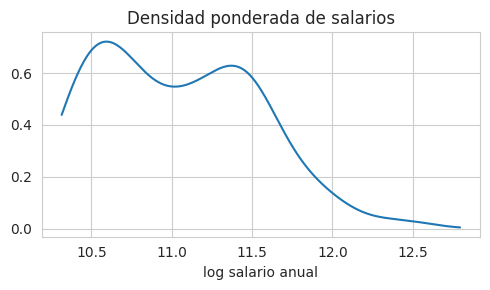

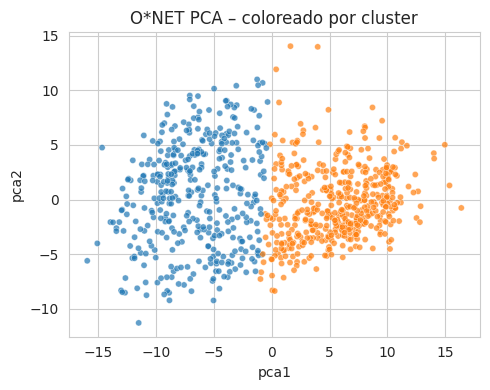

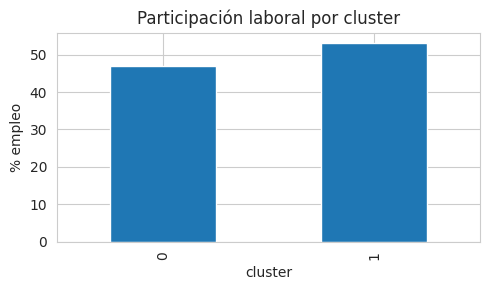

,proxy1,proxy2,proxy3,proxy4,proxy5
0,4.A.3.a.2,4.A.4.a.4,4.A.3.a.1,4.A.1.a.2,4.A.2.b.3
1,4.A.2.b.3,4.A.2.b.6,4.A.4.a.4,4.A.2.b.1,4.A.4.a.2


In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# 5) Gráficas y tablas clave                                   ║
# ╚════════════════════════════════════════════════════════════╝
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# T1 – quintiles empleo-salario
df_q = df.copy()
df_q["q5"] = pd.qcut(df_q["wage"], 5, labels=range(1,6))
tabla1 = (df_q.groupby("q5", observed=True)
            .agg(emp_total=("tot_emp","sum"),
                 wage_median=("wage","median"))
            .assign(emp_share_pct=lambda d:100*d.emp_total/d.emp_total.sum()))
display(tabla1.style.format({"emp_total":"{:,}",
                             "wage_median":"${:,.0f}",
                             "emp_share_pct":"{:.1f}%"}))

# F1 – densidad kernel ponderada log-wage
w = np.log(df["wage"])
kde = gaussian_kde(w, weights=df["tot_emp"])
xs  = np.linspace(w.min(), w.max(), 400)
plt.figure(figsize=(5,3))
plt.plot(xs, kde(xs)); plt.title("Densidad ponderada de salarios")
plt.xlabel("log salario anual"); plt.tight_layout(); plt.show()

# F2 – PCA biplot (primeras 2 componentes)
plt.figure(figsize=(5,4))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df,
                palette="tab10", s=20, alpha=.7, legend=False)
plt.title("O*NET PCA – coloreado por cluster")
plt.tight_layout(); plt.show()

# F3 – empleo por cluster
emp = (df.groupby("cluster")["tot_emp"].sum()
         .div(df["tot_emp"].sum())*100)
emp.plot(kind="bar", figsize=(5,3))
plt.ylabel("% empleo"); plt.title("Participación laboral por cluster")
plt.tight_layout(); plt.show()

# T2 – carga media de proxies top-5 por cluster (orientativo)
top5 = {}
for cl in sorted(df["cluster"].unique()):
    members = X.loc[df["cluster"]==cl]
    load = members.mean().sort_values(ascending=False)[:5]
    top5[cl] = load.index.str[:30].tolist()
pd.DataFrame.from_dict(top5, orient="index",
                       columns=[f"proxy{i}" for i in range(1,6)])


In [ ]:
# ╔════════════════════════════════════════════════════════════╗
# 6) EXPORTAR l_g, w_g/w_A y dataset limpio                    ║
# ╚════════════════════════════════════════════════════════════╝
# participaciones laborales por cluster
l_g = (df.groupby("cluster")["tot_emp"].sum()
         .div(df["tot_emp"].sum())).to_dict()

# salarios relativos (ponderados por empleo)
def w_weighted(grp):
    vals = grp["wage"].values; wts = grp["tot_emp"].values
    return np.average(vals, weights=wts)

w_abs = df.groupby("cluster").apply(w_weighted)
w_rel = (w_abs / w_abs.iloc[0]).to_dict()   # normaliza al cluster 0 (“A” manual)

targets = {"l_g": l_g, "relative_wages": w_rel, "s_K": 0.40}
import json, pandas as pd

with open("calibration_targets.json","w") as f: json.dump(targets, f, indent=2)
df.to_csv("onet_oews_clustered.csv")

print("✓ guardados: calibration_targets.json  &  onet_oews_clustered.csv")


✓ guardados: calibration_targets.json  &  onet_oews_clustered.csv


<ipython-input-7-f3088de664c5>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  w_abs = df.groupby("cluster").apply(w_weighted)


In [ ]:
import json
import numpy as np
import pandas as pd # Lo usaremos más adelante para mostrar resultados

print("--- Iniciando Configuración para Calibración del Modelo DSGE ---")

# 1. Cargar Targets Empíricos desde JSON
# Este archivo fue generado por tu pipeline de O*NET+OEWS (Celda 6 de Colab)
calibration_targets_file = "calibration_targets.json"
empirical_targets = None
try:
    with open(calibration_targets_file, "r") as f:
        empirical_targets = json.load(f)
    print(f"\nTargets empíricos cargados desde '{calibration_targets_file}':")
    print(f"  l_g (Participaciones Laborales): {empirical_targets.get('l_g')}")
    print(f"  relative_wages (w_g/w_base): {empirical_targets.get('relative_wages')}")
    print(f"  s_K (Participación del Capital): {empirical_targets.get('s_K')}")
except FileNotFoundError:
    print(f"ERROR CRÍTICO: No se encontró '{calibration_targets_file}'.")
    print("Asegúrate de que el archivo exista y la ruta sea correcta (debería estar en el directorio raíz de Colab si lo generaste en la misma sesión).")
    raise
except Exception as e:
    print(f"ERROR CRÍTICO al cargar o parsear '{calibration_targets_file}': {e}")
    raise

# Validar targets cargados
required_keys = ['l_g', 'relative_wages', 's_K']
if not all(key in empirical_targets for key in required_keys):
    print(f"ERROR CRÍTICO: Faltan claves esenciales ({required_keys}) en '{calibration_targets_file}'.")
    raise KeyError("Claves faltantes en targets empíricos.")

if not isinstance(empirical_targets['l_g'], dict) or \
   not isinstance(empirical_targets['relative_wages'], dict) or \
   not isinstance(empirical_targets['s_K'], (int, float)):
    print("ERROR CRÍTICO: Los targets empíricos no tienen el formato esperado (diccionarios para l_g/relative_wages, número para s_K).")
    raise ValueError("Formato incorrecto de targets empíricos.")

# 2. Definir Nombres de Clusters y Cluster Base para Normalización
cluster_names = sorted(empirical_targets['l_g'].keys())
if not cluster_names or len(cluster_names) != 2: # Asumiendo 2 clusters basados en tu trabajo previo
    print(f"ERROR CRÍTICO: Se esperaban 2 clusters en 'l_g', pero se encontraron {len(cluster_names)}: {cluster_names}.")
    raise ValueError("Número incorrecto de clusters o nombres de cluster no encontrados.")
base_cluster_for_norm = cluster_names[0] # Asumir que el primer cluster es la base para A_g=1

print(f"\nClusters identificados: {cluster_names}")
print(f"Cluster base para normalización de productividad (A_g=1): '{base_cluster_for_norm}'")

# 3. Definir Parámetros Fijos del Modelo DSGE (No se calibrarán en el bucle de optimización)
# Estos valores deben estar justificados por la literatura o datos externos.
# ¡AJUSTA ESTOS VALORES Y JUSTIFICACIONES SEGÚN TU INVESTIGACIÓN!

LAMBDA = 1.5  # Elasticidad de sustitución entre tareas
LAMBDA_justification = "Valor de referencia, ej. Acemoglu & Restrepo (2022)."
print(f"  lambda_ (Elasticidad de sustitución tareas): {LAMBDA:.2f} ({LAMBDA_justification})")

A_K = 1.2     # Productividad del Capital/IA (factor de aumento tecnológico)
A_K_justification = "Asumido > 1. Afecta la inferencia de Gamma_k. Sensible."
print(f"  A_k (Productividad Capital/IA): {A_K:.2f} ({A_K_justification})")

DELTA = 0.025 # Tasa de depreciación del capital (ej. trimestral)
DELTA_justification = "Estándar para depreciación trimestral (~10% anual)."
print(f"  delta (Tasa de depreciación): {DELTA:.3f} ({DELTA_justification})")

SIGMA = 1.5   # Coeficiente de aversión relativa al riesgo / Inverso de ESI
SIGMA_justification = "Valor estándar en literatura DSGE (rango 1.0-2.0)."
print(f"  sigma (Aversión al riesgo/Inv. ESI): {SIGMA:.2f} ({SIGMA_justification})")

A_base_value = 1.0 # Productividad del cluster base (normalización)
print(f"  A_{base_cluster_for_norm} (Productividad Cluster Base): {A_base_value:.2f} (Normalización)")

# Consolidar parámetros fijos que se usarán en las funciones de calibración
fixed_params_for_calibration_dsge = {
    'lambda_': LAMBDA,
    'A_k': A_K,
    'delta': DELTA,
    'sigma': SIGMA,
    'cluster_names': cluster_names, # Lista con los nombres de los clusters, ej. ['0', '1']
    'base_cluster_name': base_cluster_for_norm,
    'A_base_value': A_base_value    # Valor de A_g para el cluster base
}
# Añadir L_g (ofertas de trabajo por cluster, de targets) al diccionario de parámetros fijos
for cn in cluster_names:
    fixed_params_for_calibration_dsge[f'L_{cn}'] = empirical_targets['l_g'][cn]
# Añadir A_g del cluster base explícitamente con su nombre de cluster
fixed_params_for_calibration_dsge[f'A_{base_cluster_for_norm}'] = A_base_value

print("\nDiccionario `fixed_params_for_calibration_dsge` (contiene parámetros fijos para el optimizador):")
for key, value in fixed_params_for_calibration_dsge.items():
    if isinstance(value, float): print(f"  '{key}': {value:.4f}")
    else: print(f"  '{key}': {value}")

# 4. Definir los Parámetros que SÍ se van a Calibrar por el Optimizador
# Para este modelo DSGE, calibraremos 'beta' y el 'A_g' del cluster no base.
parameters_to_calibrate_dsge = ['beta'] # Siempre calibraremos beta
for cn in cluster_names:
    if cn != base_cluster_for_norm:
        parameters_to_calibrate_dsge.append(f'A_{cn}') # ej. si base es '0', esto añade 'A_1'

print(f"\nParámetros que se calibrarán por el optimizador: {parameters_to_calibrate_dsge}")
print("   (El orden en esta lista será importante para los valores iniciales y los resultados del optimizador)")

print("\n--- Fin de la Celda A: Configuración de Parámetros y Targets para DSGE ---")

--- Iniciando Configuración para Calibración del Modelo DSGE ---

Targets empíricos cargados desde 'calibration_targets.json':
  l_g (Participaciones Laborales): {'0': 0.46850668392226236, '1': 0.5314933160777376}
  relative_wages (w_g/w_base): {'0': 1.0, '1': 2.2604287373005856}
  s_K (Participación del Capital): 0.4

Clusters identificados: ['0', '1']
Cluster base para normalización de productividad (A_g=1): '0'
  lambda_ (Elasticidad de sustitución tareas): 1.50 (Valor de referencia, ej. Acemoglu & Restrepo (2022).)
  A_k (Productividad Capital/IA): 1.20 (Asumido > 1. Afecta la inferencia de Gamma_k. Sensible.)
  delta (Tasa de depreciación): 0.025 (Estándar para depreciación trimestral (~10% anual).)
  sigma (Aversión al riesgo/Inv. ESI): 1.50 (Valor estándar en literatura DSGE (rango 1.0-2.0).)
  A_0 (Productividad Cluster Base): 1.00 (Normalización)

Diccionario `fixed_params_for_calibration_dsge` (contiene parámetros fijos para el optimizador):
  'lambda_': 1.5000
  'A_k': 1.200

In [ ]:
import numpy as np
import pandas as pd # No es estrictamente necesario aquí, pero es bueno si se usa en otros lugares

print("--- Celda B: Definiendo la función 'solve_equilibrium' adaptada para clusters ---")

def solve_equilibrium(Gammas, params):
    """
    Calcula el output, la participación del capital y los salarios
    directamente a partir de las cuotas de tarea (Gammas) fijas y los parámetros.
    ADAPTADA PARA NOMBRES DE CLUSTER VARIABLES.

    Args:
        Gammas (dict): Diccionario con las cuotas de tarea.
                       Ej: {'Gamma_k': 0.4, 'Gamma_0': 0.3, 'Gamma_1': 0.3}
        params (dict): Diccionario con los parámetros del modelo, incluyendo:
                       'lambda_', 'A_k', 'cluster_names' (ej. ['0', '1']),
                       y para cada cluster 'c' en cluster_names:
                       'L_c' (oferta de trabajo), 'A_c' (productividad).

    Returns:
        dict: Un diccionario con 'y' (output), 's_K' (participación del capital),
              y 'w_c' para cada cluster c (salario).
              Devuelve un diccionario con NaNs si hay errores o parámetros inválidos.
    """
    lambda_ = params.get('lambda_')
    A_k = params.get('A_k')
    cluster_names = params.get('cluster_names')

    # Inicializar diccionario de resultados con NaNs para asegurar que todas las claves existan
    nan_wages = {f'w_{g_name}': np.nan for g_name in (cluster_names if cluster_names else [])}
    default_return = {'y': np.nan, 's_K': np.nan, **nan_wages}

    if None in [lambda_, A_k, cluster_names]:
        return default_return

    Gamma_k = Gammas.get('Gamma_k')
    if Gamma_k is None:
        return default_return

    if np.isclose(lambda_, 1.0) or lambda_ <= 0: # lambda debe ser positivo y no 1
        return default_return

    if A_k <= 0 :
        return default_return

    try:
        s_K_model = (A_k**(lambda_ - 1)) * Gamma_k
    except (OverflowError, ValueError):
        return default_return

    if not (0 <= s_K_model < 1): # s_K_model debe estar en [0,1)
        s_K_model = np.clip(s_K_model, 0, 1-1e-9) # Clip para evitar errores, pero indica problema

    labor_term_sum = 0.0
    valid_labor_terms = 0
    for g_name in cluster_names:
        L_g = params.get(f'L_{g_name}')
        A_g = params.get(f'A_{g_name}')
        Gamma_g = Gammas.get(f'Gamma_{g_name}')

        if None in [L_g, A_g, Gamma_g] or L_g < 0 or A_g < 0 or Gamma_g < 0:
            continue

        if L_g > 1e-9 and Gamma_g > 1e-9 and A_g > 1e-9: # Solo si son estrictamente positivos
            try:
                base_term = A_g * L_g
                # No es necesario abs si A_g y L_g son positivos.
                term = (Gamma_g**(1/lambda_)) * (base_term**((lambda_ - 1)/lambda_))
                if np.isfinite(term):
                    labor_term_sum += term
                    valid_labor_terms += 1
            except (ValueError, OverflowError, ZeroDivisionError):
                pass

    y = np.nan
    if not np.isfinite(s_K_model) or s_K_model >= 1-1e-9: # Si s_K es 1 o más
        y = 0.0 if labor_term_sum == 0 else np.nan
    elif labor_term_sum < 1e-9 and valid_labor_terms == 0: # No hay contribución laboral efectiva
         y = 0.0
    else:
        try:
            factor1_base = 1 - s_K_model
            factor2_base = labor_term_sum

            if factor1_base <= 1e-9: y = 0.0
            elif factor2_base < 0 : y = np.nan # No debería ocurrir
            else:
                # Proteger exponentes
                exp1 = lambda_ / (1 - lambda_)
                exp2 = lambda_ / (lambda_ - 1)
                if (factor1_base < 0 and exp1 != round(exp1)) or \
                   (factor2_base < 0 and exp2 != round(exp2)):
                     y = np.nan
                else:
                    term1 = factor1_base**exp1
                    term2 = factor2_base**exp2
                    y = term1 * term2
        except (ValueError, OverflowError, ZeroDivisionError):
            y = np.nan

    if not np.isfinite(y): y = np.nan

    results = {'y': y, 's_K': s_K_model}
    for g_name in cluster_names:
        L_g = params.get(f'L_{g_name}')
        A_g = params.get(f'A_{g_name}')
        Gamma_g = Gammas.get(f'Gamma_{g_name}')

        w_g_val = np.nan
        if None not in [L_g, A_g, Gamma_g] and pd.notna(y) and y > 1e-9 and \
           L_g > 1e-9 and A_g > 1e-9 and Gamma_g > 1e-9:
            try:
                part1 = (y / L_g)**(1/lambda_)
                part2 = (A_g)**((lambda_ - 1)/lambda_)
                part3 = (Gamma_g)**(1/lambda_)
                w_g_val = part1 * part2 * part3
            except (ValueError, OverflowError, ZeroDivisionError):
                w_g_val = np.nan

        if not np.isfinite(w_g_val): w_g_val = np.nan
        results[f'w_{g_name}'] = w_g_val

    return results

print("Función `solve_equilibrium` adaptada para clusters está definida.")
print("NOTA: Esta función es para el modelo ESTÁTICO y se usará como helper.")

--- Celda B: Definiendo la función 'solve_equilibrium' adaptada para clusters ---
Función `solve_equilibrium` adaptada para clusters está definida.
NOTA: Esta función es para el modelo ESTÁTICO y se usará como helper.


In [ ]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd # Para la prueba al final
import traceback # Para imprimir errores detallados si ocurren

print("--- Celda C: Definiendo la función 'solve_steady_state_DSGE' ---")

# Verificar que las funciones y variables necesarias de celdas anteriores existen
required_vars_for_stepC = [
    'empirical_targets',
    'fixed_params_for_calibration_dsge',
    'solve_equilibrium',
    'cluster_names',
    'base_cluster_for_norm'
]
missing_vars_stepC = [var for var in required_vars_for_stepC if var not in globals()]
if missing_vars_stepC:
    print(f"ERROR CRÍTICO: Faltan variables o funciones de celdas anteriores: {missing_vars_stepC}.")
    print("               Asegúrate de haber ejecutado la Celda A (configuración) y la Celda B (definición de `solve_equilibrium`).")
    raise NameError(f"Dependencias no encontradas para la Celda C: {missing_vars_stepC}")


def solve_steady_state_DSGE(current_A_params_dict, # Diccionario con los A_g que se están probando (ej. {'A_0':1.0, 'A_1':1.5})
                            beta_trial, # Valor de beta que se está probando
                            # fixed_params contiene lambda, A_k, L_g, cluster_names, delta, sigma, A_base_val
                            fixed_params,
                            s_K_target_from_data,
                            initial_K_guess_val=10.0
                           ):
    """
    Calcula el estado estacionario del modelo DSGE simplificado.
    Encuentra K_ss tal que PML_K (derivada del modelo estático) = (1/beta) - 1 + delta.
    Luego calcula C_ss, I_ss, Y_ss, r_ss, w_0_ss, w_1_ss.
    Las Gammas se calculan internamente para ser consistentes con s_K_target.
    """
    # Desempaquetar parámetros dinámicos y clave
    delta = fixed_params.get('delta')
    lambda_ = fixed_params.get('lambda_')
    A_k = fixed_params.get('A_k')
    cluster_names_list_ss = fixed_params.get('cluster_names')

    if None in [beta_trial, delta, lambda_, A_k, cluster_names_list_ss]:
        return None
    if not (0 < beta_trial < 1):
        return None

    # Construir el diccionario de parámetros para la parte estática (solve_equilibrium)
    params_for_static_solver = {
        'lambda_': lambda_, 'A_k': A_k, 'cluster_names': cluster_names_list_ss
    }
    for cn in cluster_names_list_ss:
        params_for_static_solver[f'L_{cn}'] = fixed_params.get(f'L_{cn}')
        # `current_A_params_dict` debe tener la forma {'A_0': valor, 'A_1': valor}
        params_for_static_solver[f'A_{cn}'] = current_A_params_dict.get(f'A_{cn}')
        if params_for_static_solver[f'L_{cn}'] is None or params_for_static_solver[f'A_{cn}'] is None:
            return None

    # Calcular Gammas base consistentes con s_K_target
    Gammas_ss = {}
    # Usar A_k del dict de params que va a solve_equilibrium
    A_k_model_for_gamma = params_for_static_solver['A_k']
    lambda_model_for_gamma = params_for_static_solver['lambda_']

    if A_k_model_for_gamma**(lambda_model_for_gamma - 1) <= 1e-9: return None
    Gamma_k_ss = s_K_target_from_data / (A_k_model_for_gamma**(lambda_model_for_gamma - 1))
    if not (0 <= Gamma_k_ss < 1-1e-9): return None

    Gamma_L_ss = 1.0 - Gamma_k_ss
    if Gamma_L_ss < -1e-9: return None
    Gamma_L_ss = max(0, Gamma_L_ss)

    Gammas_ss['Gamma_k'] = Gamma_k_ss
    total_Lg_for_dist = sum(params_for_static_solver.get(f'L_{cn}', 0) for cn in cluster_names_list_ss)
    if np.isclose(total_Lg_for_dist, 0) and Gamma_L_ss > 1e-9 : return None

    for cn in cluster_names_list_ss:
        lg_val = params_for_static_solver.get(f'L_{cn}', 0)
        Gammas_ss[f'Gamma_{cn}'] = Gamma_L_ss * (lg_val / total_Lg_for_dist) if total_Lg_for_dist > 1e-9 else 0.0

    PML_K_ss_target_from_euler = (1/beta_trial) - 1 + delta
    if PML_K_ss_target_from_euler <= 0: return None

    def capital_equilibrium_residual(K_ss_guess_array):
        K_ss_val = K_ss_guess_array[0]
        if K_ss_val <= 1e-6: return 1e12

        eq_results = solve_equilibrium(Gammas_ss, params_for_static_solver)

        if eq_results is None or pd.isna(eq_results.get('y')) or eq_results.get('y') <= 1e-9 \
           or pd.isna(eq_results.get('s_K')):
            return 1e11

        Y_model_ss_val = eq_results['y']
        s_K_model_val = eq_results['s_K']

        PML_K_model_gross = (s_K_model_val * Y_model_ss_val) / K_ss_val
        residuo = PML_K_model_gross - PML_K_ss_target_from_euler
        return residuo

    try:
        solution_K_ss_array, infodict, ier, mesg = fsolve(
            capital_equilibrium_residual, x0=np.array([initial_K_guess_val]),
            full_output=True, xtol=1e-8
        )

        if ier == 1:
            K_ss_solved = solution_K_ss_array[0]
            if K_ss_solved <= 1e-6: return None

            final_eq_vars = solve_equilibrium(Gammas_ss, params_for_static_solver)
            if final_eq_vars is None or pd.isna(final_eq_vars.get('y')): return None

            Y_ss = final_eq_vars['y']
            I_ss = delta * K_ss_solved
            C_ss = Y_ss - I_ss

            if C_ss <= 1e-6: return None

            steady_state_solution = {
                'K_ss': K_ss_solved, 'Y_ss': Y_ss, 'C_ss': C_ss, 'I_ss': I_ss,
                'r_ss_net': PML_K_ss_target_from_euler - delta,
                'R_ss_gross': PML_K_ss_target_from_euler,
                's_K_ss_model_check': final_eq_vars.get('s_K'),
                **{f'w_{cn}_ss': final_eq_vars.get(f'w_{cn}') for cn in cluster_names_list_ss}
            }
            return steady_state_solution
        else:
            return None
    except Exception:
        return None

# --- PRUEBA de solve_steady_state_DSGE ---
print("\nProbando `solve_steady_state_DSGE`...")

# Usar `fixed_params_for_calibration_dsge` que ya tiene L_g, A_0, lambda, A_k, delta, sigma
test_params_for_ss_function = fixed_params_for_calibration_dsge.copy()
test_params_for_ss_function['beta'] = 0.99 # Valor de prueba para beta

# Construir el diccionario de A_g para la prueba
current_A_params_dict_for_test = {}
for cn_test in cluster_names: # cluster_names fue definido en Celda A
    if cn_test == base_cluster_for_norm: # base_cluster_for_norm fue definido en Celda A
        current_A_params_dict_for_test[f'A_{cn_test}'] = test_params_for_ss_function[f'A_{cn_test}'] # Toma A_base de fixed_params
    else:
        # Para el A_g no base (ej. A_1), usa un valor de prueba.
        current_A_params_dict_for_test[f'A_{cn_test}'] = 2.0 # Ejemplo para A_1

print(f"  [SS_TEST_DEBUG] current_A_params_dict para prueba: {current_A_params_dict_for_test}")
print(f"  [SS_TEST_DEBUG] beta para prueba: {test_params_for_ss_function['beta']}")

ss_results = solve_steady_state_DSGE(
    current_A_params_dict=current_A_params_dict_for_test,
    beta_trial=test_params_for_ss_function['beta'],
    fixed_params=test_params_for_ss_function,
    s_K_target_from_data=empirical_targets['s_K'],
    initial_K_guess_val=25.0
)

if ss_results:
    print("\nPrueba de Estado Estacionario DSGE Encontrado:")
    for var, val in ss_results.items():
        if isinstance(val, float): print(f"  {var}: {val:.4f}")
        else: print(f"  {var}: {val}")
else:
    print("\nNo se pudo encontrar el estado estacionario de prueba para el modelo DSGE.")
    print("  Revisa la función `solve_steady_state_DSGE`, especialmente la lógica de `capital_equilibrium_residual`")
    print("  y asegúrate de que `solve_equilibrium` devuelva resultados válidos con los parámetros de prueba.")

print("\n--- Fin de la Celda C (DSGE): Definición de `solve_steady_state_DSGE` ---")

--- Celda C: Definiendo la función 'solve_steady_state_DSGE' ---

Probando `solve_steady_state_DSGE`...
  [SS_TEST_DEBUG] current_A_params_dict para prueba: {'A_0': 1.0, 'A_1': 2.0}
  [SS_TEST_DEBUG] beta para prueba: 0.99

Prueba de Estado Estacionario DSGE Encontrado:
  K_ss: 31.3491
  Y_ss: 2.7510
  C_ss: 1.9672
  I_ss: 0.7837
  r_ss_net: 0.0101
  R_ss_gross: 0.0351
  s_K_ss_model_check: 0.4000
  w_0_ss: 1.4502
  w_1_ss: 1.8272

--- Fin de la Celda C (DSGE): Definición de `solve_steady_state_DSGE` ---


In [ ]:
import numpy as np
import pandas as pd # Para la prueba al final

print("--- Celda D (Paso 4 DSGE): Definiendo la Función Objetivo para la Calibración ---")

# --- 1. Verificar que las variables y funciones necesarias existen ---
# Estas variables deben venir de tu Celda A y la función de la Celda C.
required_vars_for_stepD = [
    'empirical_targets',
    'cluster_names',
    'base_cluster_for_norm',
    'fixed_params_for_calibration_dsge', # Diccionario con L_g, A_base_val, lambda_, A_k, delta, sigma
    'parameters_to_calibrate_dsge', # Lista de nombres de parámetros a calibrar, ej. ['beta', 'A_1']
    'solve_steady_state_DSGE'       # Función que resuelve el EE dinámico (definida en Celda C)
]
missing_vars_stepD = [var for var in required_vars_for_stepD if var not in globals()]
if missing_vars_stepD:
    print(f"ERROR CRÍTICO: Faltan variables o funciones de celdas anteriores: {missing_vars_stepD}.")
    print("               Asegúrate de haber ejecutado las celdas anteriores correctamente:")
    print("               - Celda A (configuración de targets y parámetros fijos).")
    print("               - Celda B (definición de `solve_equilibrium` - helper).")
    print("               - Celda C (definición de `solve_steady_state_DSGE`).")
    raise NameError(f"Dependencias no encontradas para la Celda D: {missing_vars_stepD}")


# --- 2. Definir la Función Objetivo DSGE ---
def objective_function_DSGE(params_to_calibrate_values, # Array/lista con los valores que el optimizador está probando (ej. [beta_trial, A1_trial])
                            # Argumentos adicionales que pasará el optimizador (args):
                            param_names_being_calibrated_list, # Lista de nombres de esos parámetros (ej. ['beta', 'A_1'])
                            fixed_params_dict_arg,             # Diccionario con params fijos (L_g, A_base, lambda, A_k, delta, sigma, etc.)
                            all_empirical_targets_dict_arg     # Diccionario completo de targets empíricos (l_g, relative_wages, s_K)
                           ):
    """
    Calcula la suma de los errores cuadráticos ponderados entre las predicciones
    del estado estacionario del modelo DSGE y los targets empíricos.
    """
    # print(f"\n  [OBJ_FUNC_DSGE DEBUG] params_to_calibrate_values: {params_to_calibrate_values}")

    # A. Construir el diccionario completo de A_g y extraer beta para esta iteración
    current_A_dict_for_ss = {}
    beta_trial_from_optimizer = None

    # El A_g del cluster base siempre se toma de fixed_params_dict_arg
    current_A_dict_for_ss[f"A_{fixed_params_dict_arg['base_cluster_name']}"] = fixed_params_dict_arg['A_base_value']

    for i, param_key_name in enumerate(param_names_being_calibrated_list):
        if param_key_name == 'beta':
            beta_trial_from_optimizer = params_to_calibrate_values[i]
        elif param_key_name.startswith('A_'): # Es un A_g de un cluster no base
            # El nombre del cluster es la parte después de 'A_'
            # cluster_name_for_A = param_key_name.split('_')[1]
            # No, param_key_name ya es 'A_X', current_A_dict_for_ss_solver espera 'A_X': valor
            current_A_dict_for_ss[param_key_name] = params_to_calibrate_values[i]

    if beta_trial_from_optimizer is None: # Si beta no se está calibrando, debe estar en fixed_params_dict_arg
        beta_trial_from_optimizer = fixed_params_dict_arg.get('beta') # Asume que lo pusiste allí si no se calibra
        if beta_trial_from_optimizer is None:
            # print("  [OBJ_FUNC_DSGE DEBUG] Beta no se está calibrando ni está en fixed_params. Error.")
            return 1e12 # Penalización muy alta

    # B. Resolver el estado estacionario del modelo DSGE
    #    `fixed_params_dict_arg` ya tiene delta, sigma, lambda, A_k, L_g, etc.
    steady_state_results = solve_steady_state_DSGE(
        current_A_params_dict=current_A_dict_for_ss, # Contiene todos los A_g (base y los que se prueban)
        beta_trial=beta_trial_from_optimizer,
        fixed_params=fixed_params_dict_arg,
        s_K_target_from_data=all_empirical_targets_dict_arg['s_K']
        # initial_K_guess_val se puede añadir si es necesario refinarlo
    )

    if steady_state_results is None:
        # print("  [OBJ_FUNC_DSGE DEBUG] solve_steady_state_DSGE retornó None. Penalización alta.")
        return 1e11

    # C. Extraer predicciones del modelo y targets empíricos
    model_sK = steady_state_results.get('s_K_ss_model_check')
    w_base_model_ss = steady_state_results.get(f"w_{fixed_params_dict_arg['base_cluster_name']}_ss")

    if w_base_model_ss is None or w_base_model_ss <= 1e-9 or not np.isfinite(w_base_model_ss):
        # print(f"  [OBJ_FUNC_DSGE DEBUG] Salario base del EE w_{fixed_params_dict_arg['base_cluster_name']}_ss inválido: {w_base_model_ss}")
        return 1e10

    model_relative_wages = {}
    for cluster_name_idx in fixed_params_dict_arg['cluster_names']:
        if cluster_name_idx == fixed_params_dict_arg['base_cluster_name']:
            model_relative_wages[cluster_name_idx] = 1.0
        else:
            w_g_model_ss = steady_state_results.get(f'w_{cluster_name_idx}_ss')
            if w_g_model_ss is None or not np.isfinite(w_g_model_ss) or w_g_model_ss < 0:
                return 1e9
            model_relative_wages[cluster_name_idx] = w_g_model_ss / w_base_model_ss

    target_relative_wages = all_empirical_targets_dict_arg['relative_wages']
    target_sK = all_empirical_targets_dict_arg['s_K']

    # D. Calcular la suma de errores cuadráticos
    sum_squared_errors = 0.0
    # Ponderaciones (puedes ajustarlas si quieres dar más importancia a un target)
    weights = {'relative_wage': 1.0, 's_K': 1.0}

    # Error para salarios relativos
    num_wage_targets_compared = 0
    for cn_obj_err in fixed_params_dict_arg['cluster_names']:
        if cn_obj_err == fixed_params_dict_arg['base_cluster_name']:
            continue # El salario relativo del base es 1 por definición

        model_val = model_relative_wages.get(cn_obj_err)
        target_val = target_relative_wages.get(cn_obj_err)

        if model_val is None or target_val is None or not np.isfinite(model_val) or not np.isfinite(target_val):
            sum_squared_errors += 1e5 * weights['relative_wage']; continue # Penalización grande

        # Usar error porcentual al cuadrado
        if abs(target_val) < 1e-9: # Evitar división por cero si el target es (casi) cero
            error = model_val - target_val
        else:
            error = (model_val - target_val) / target_val

        sum_squared_errors += (error**2) * weights['relative_wage']
        num_wage_targets_compared +=1

    if num_wage_targets_compared == 0 and len(fixed_params_dict_arg['cluster_names']) > 1 : # Si solo hay un cluster, no hay salarios relativos que comparar
        sum_squared_errors += 1e8 # Penalización si no se comparó ningún salario relativo (y debería haberlo hecho)

    # Error para s_K
    if model_sK is None or not np.isfinite(model_sK):
        sum_squared_errors += 1e5 * weights['s_K']
    else:
        if abs(target_sK) < 1e-9: error_sK = model_sK - target_sK
        else: error_sK = (model_sK - target_sK) / target_sK
        sum_squared_errors += (error_sK**2) * weights['s_K']

    # print(f"  [OBJ_FUNC_DSGE DEBUG] Valores calibrando: {params_to_calibrate_values}, Error Total: {sum_squared_errors:.6e}")
    return sum_squared_errors

# --- PRUEBA de la función objetivo DSGE ---
print("\nProbando `objective_function_DSGE` con valores de ejemplo...")

# `parameters_to_calibrate_dsge` fue definido en la Celda A, ej. ['beta', 'A_1']
# `fixed_params_for_calibration_dsge` fue definido en la Celda A
# `empirical_targets` fue cargado en la Celda A

example_params_to_calibrate_values_dsge = []
if 'parameters_to_calibrate_dsge' in globals() and parameters_to_calibrate_dsge:
    for param_name_test in parameters_to_calibrate_dsge:
        if param_name_test == 'beta':
            example_params_to_calibrate_values_dsge.append(0.99) # Valor de prueba para beta
        elif param_name_test.startswith('A_'):
            # Usar el A_1 calibrado del modelo estático como conjetura, o el target de salario relativo
            # Si el target w1/w0 es 2.26, usar A_1 = 2.26 (asumiendo A_0=1)
            cluster_key_for_test = param_name_test.split('_')[1]
            example_params_to_calibrate_values_dsge.append(
                empirical_targets['relative_wages'].get(cluster_key_for_test, 1.5) # Default a 1.5 si no se encuentra
            )

    print(f"  Valores de prueba para {parameters_to_calibrate_dsge}: {example_params_to_calibrate_values_dsge}")

    test_error_dsge = objective_function_DSGE(
        example_params_to_calibrate_values_dsge,
        parameters_to_calibrate_dsge,          # Nombres de los parámetros que se están probando
        fixed_params_for_calibration_dsge, # Diccionario de parámetros fijos
        empirical_targets                  # Diccionario de targets empíricos
    )
    print(f"Error DSGE calculado con valores de ejemplo: {test_error_dsge:.6e}")
    print("  (Un error muy pequeño indica que los parámetros de ejemplo hacen que el estado estacionario del modelo DSGE replique bien los targets).")
else:
    print("  INFO: No hay parámetros definidos en `parameters_to_calibrate_dsge` para la prueba, o falta alguna variable global.")


print("\n--- Fin de la Celda D (Paso 4 DSGE): Función Objetivo Definida ---")

--- Celda D (Paso 4 DSGE): Definiendo la Función Objetivo para la Calibración ---

Probando `objective_function_DSGE` con valores de ejemplo...
  Valores de prueba para ['beta', 'A_1']: [0.99, 2.2604287373005856]
Error DSGE calculado con valores de ejemplo: 1.759011e-01
  (Un error muy pequeño indica que los parámetros de ejemplo hacen que el estado estacionario del modelo DSGE replique bien los targets).

--- Fin de la Celda D (Paso 4 DSGE): Función Objetivo Definida ---


In [ ]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd # Para mostrar los resultados finales de manera ordenada
import traceback # Para imprimir errores detallados si ocurren

print("--- Celda E (Paso 5 DSGE): Ejecutando el Optimizador para Calibrar Parámetros del Modelo DSGE ---")

# --- 1. Verificar que las variables y funciones necesarias existen ---
required_vars_for_stepE = [
    'empirical_targets',
    'cluster_names',
    'base_cluster_for_norm',
    'fixed_params_for_calibration_dsge', # Definido en Celda A (Paso 1 de Calibración DSGE)
    'parameters_to_calibrate_dsge',    # Definido en Celda A (ej. ['beta', 'A_1'])
    'objective_function_DSGE',         # Definido en Celda D (Paso 4 DSGE)
    'solve_steady_state_DSGE',         # Definido en Celda C (Paso 3 DSGE)
    'solve_equilibrium'                # Definido en Celda B
]
missing_vars_stepE = [var for var in required_vars_for_stepE if var not in globals()]
if missing_vars_stepE:
    print(f"ERROR CRÍTICO: Faltan variables o funciones de celdas anteriores: {missing_vars_stepE}.")
    raise NameError(f"Dependencias no encontradas para la Celda E: {missing_vars_stepE}")

# --- 2. Valores Iniciales y Cotas para los Parámetros a Calibrar ---
# `parameters_to_calibrate_dsge` fue definido en la Celda A, ej. ['beta', 'A_1']

initial_guesses_dsge = []
bounds_dsge = []

for param_name in parameters_to_calibrate_dsge:
    if param_name == 'beta':
        initial_guesses_dsge.append(0.99)    # Conjetura inicial para beta
        bounds_dsge.append((0.90, 0.999)) # Beta debe estar entre 0 y 1 (pero no muy en los extremos)
    elif param_name.startswith('A_'):
        # Usar el target del salario relativo como conjetura inicial para A_g no base
        cluster_key = param_name.split('_')[1]
        initial_guess_A = empirical_targets['relative_wages'].get(cluster_key, 1.5) # Default a 1.5 si no se encuentra
        initial_guesses_dsge.append(initial_guess_A)
        bounds_dsge.append((0.01, 20.0)) # Ejemplo: A_g entre 0.01 y 20.0
    else:
        print(f"ADVERTENCIA: Parámetro desconocido '{param_name}' en `parameters_to_calibrate_dsge`. Usando guess=1.0, bounds=(0.01,10)")
        initial_guesses_dsge.append(1.0)
        bounds_dsge.append((0.01,10.0))


print(f"\nParámetros a calibrar por el optimizador: {parameters_to_calibrate_dsge}")
print(f"Valores iniciales: {initial_guesses_dsge}")
print(f"Cotas (bounds): {bounds_dsge}")

# --- 3. Ejecutar el Optimizador ---
# Usaremos 'L-BFGS-B' que puede manejar cotas, o 'Nelder-Mead' que es más robusto a funciones no suaves.
# 'Nelder-Mead' no usa 'bounds' directamente en la llamada a minimize, pero podemos poner validaciones en la función objetivo.
# 'L-BFGS-B' es bueno si la función es relativamente suave.

print("\nIniciando optimización del modelo DSGE (puede tardar un momento)...")
optimization_result_dsge = minimize(
    objective_function_DSGE,
    initial_guesses_dsge,
    args=(parameters_to_calibrate_dsge,       # Nombres de los parámetros que corresponden a initial_guesses_dsge
          fixed_params_for_calibration_dsge,  # Parámetros fijos del modelo
          empirical_targets                   # Targets empíricos completos
         ),
    method='L-BFGS-B', # Un método que respeta cotas
    bounds=bounds_dsge,
    # method='Nelder-Mead', # Alternativa si L-BFGS-B no funciona bien
    options={'disp': True, 'maxiter': 200, 'ftol': 1e-9, 'gtol': 1e-7} # Aumentar iteraciones y ajustar tolerancias
)

# --- 4. Resultados de la Optimización ---
optimization_successful_dsge = optimization_result_dsge.success
final_calibrated_params_dsge_dict = {}

if optimization_successful_dsge:
    calibrated_values_dsge = optimization_result_dsge.x
    print("\n¡Optimización DSGE Finalizada Exitosamente!")
    print(f"  Mensaje del optimizador: {optimization_result_dsge.message}")
    print(f"  Valor final de la función objetivo (error): {optimization_result_dsge.fun:.8e}")

    # Construir el diccionario con los parámetros calibrados
    for i, param_name_result in enumerate(parameters_to_calibrate_dsge):
        final_calibrated_params_dsge_dict[param_name_result] = calibrated_values_dsge[i]

    print("\nValores Calibrados para los Parámetros Optimizados:")
    for p_name, val in final_calibrated_params_dsge_dict.items():
        print(f"  {p_name} = {val:.4f}")
else:
    print("\nLa optimización DSGE NO convergió o falló.")
    print(f"  Mensaje del optimizador: {optimization_result_dsge.message}")
    print(f"  Último valor de la función objetivo: {optimization_result_dsge.fun:.8e}")
    # Guardar los últimos valores probados si falló, podrían ser útiles
    last_tried_values = optimization_result_dsge.x
    for i, param_name_result in enumerate(parameters_to_calibrate_dsge):
        final_calibrated_params_dsge_dict[param_name_result] = last_tried_values[i]
    print(f"  Últimos valores probados: {final_calibrated_params_dsge_dict}")

# --- 5. Construir el Diccionario Completo de Parámetros del Modelo DSGE Calibrado ---
print("\n--- DICCIONARIO COMPLETO DE PARÁMETROS DEL MODELO DSGE CALIBRADO ---")
# Empezar con los fijos y actualizar/añadir los calibrados
full_calibrated_dsge_params = fixed_params_for_calibration_dsge.copy()
full_calibrated_dsge_params.update(final_calibrated_params_dsge_dict) # Añade/sobrescribe beta, A_1, etc.

print("Parámetros del Modelo DSGE Calibrado (`full_calibrated_dsge_params`):")
for key, value in full_calibrated_dsge_params.items():
    if isinstance(value, float): print(f"  '{key}': {value:.4f}")
    else: print(f"  '{key}': {value}")

# --- 6. VERIFICACIÓN FINAL con los Parámetros Calibrados del DSGE ---
if optimization_successful_dsge:
    print("\n--- Verificación Final del Modelo DSGE Calibrado ---")
    # Extraer los A_g y beta calibrados para pasarlos a solve_steady_state_DSGE
    calibrated_A_dict_for_verif = {}
    beta_calibrated_for_verif = None
    for cn_verif in cluster_names: # cluster_names es de la Celda A
        a_key_verif = f'A_{cn_verif}'
        calibrated_A_dict_for_verif[a_key_verif] = full_calibrated_dsge_params[a_key_verif]
    beta_calibrated_for_verif = full_calibrated_dsge_params['beta']

    try:
        final_ss_results = solve_steady_state_DSGE(
            current_A_params_dict=calibrated_A_dict_for_verif,
            beta_trial=beta_calibrated_for_verif,
            fixed_params=full_calibrated_dsge_params, # Contiene todo lo demás (delta, sigma, L_g, etc.)
            s_K_target_from_data=empirical_targets['s_K']
        )

        if final_ss_results:
            print("\nResultados del Estado Estacionario con Parámetros DSGE Calibrados:")
            for var, val in final_ss_results.items():
                if isinstance(val, float): print(f"  {var}: {val:.4f}")
                else: print(f"  {var}: {val}")

            # Comparar con targets
            model_sK_final_verif = final_ss_results.get('s_K_ss_model_check')
            target_sK_final_verif = empirical_targets['s_K']
            print(f"\nComparación s_K:")
            print(f"  Target Empírico: {target_sK_final_verif:.4f}")
            print(f"  Modelo Calibrado: {model_sK_final_verif:.4f} (Diferencia: {model_sK_final_verif - target_sK_final_verif:.4g})")

            w_base_final_verif = final_ss_results.get(f"w_{base_cluster_for_norm}_ss")
            if w_base_final_verif and w_base_final_verif > 1e-9:
                verif_final_rel_wages = {}
                for cn_verif_w in cluster_names:
                    wg_val_verif = final_ss_results.get(f'w_{cn_verif_w}_ss')
                    verif_final_rel_wages[cn_verif_w] = wg_val_verif / w_base_final_verif if pd.notna(wg_val_verif) else np.nan

                print("\nComparación de Salarios Relativos Finales (w_g / w_base_cluster):")
                comp_final_df_data_dsge = []
                for g_name_comp in cluster_names:
                    target_val_dsge = empirical_targets['relative_wages'].get(g_name_comp, np.nan)
                    model_val_dsge = verif_final_rel_wages.get(g_name_comp, np.nan)
                    diff_dsge = model_val_dsge - target_val_dsge if pd.notna(target_val_dsge) and pd.notna(model_val_dsge) else np.nan
                    comp_final_df_data_dsge.append({'Cluster': g_name_comp, 'Target Empírico': target_val_dsge, 'Modelo Calibrado': model_val_dsge, 'Diferencia': diff_dsge})
                print(pd.DataFrame(comp_final_df_data_dsge).to_string(index=False, float_format='{:.4f}'.format))
            else:
                print(f"  ERROR en verificación final: Salario base del cluster w_{base_cluster_for_norm}_ss inválido.")
        else:
            print("ERROR: `solve_steady_state_DSGE` no devolvió resultados válidos en la verificación final.")
    except Exception as e_verif_final_dsge:
        print(f"ERROR CRÍTICO durante la verificación final del modelo DSGE: {e_verif_final_dsge}")
        traceback.print_exc()
else:
    print("\nNo se pudo completar la optimización DSGE. No se pueden generar parámetros finales completos ni verificar.")

print("\n--- Fin de la Celda E (Paso 5 DSGE): Optimización y Resultados ---")

--- Celda E (Paso 5 DSGE): Ejecutando el Optimizador para Calibrar Parámetros del Modelo DSGE ---

Parámetros a calibrar por el optimizador: ['beta', 'A_1']
Valores iniciales: [0.99, 2.2604287373005856]
Cotas (bounds): [(0.9, 0.999), (0.01, 20.0)]

Iniciando optimización del modelo DSGE (puede tardar un momento)...

¡Optimización DSGE Finalizada Exitosamente!
  Mensaje del optimizador: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  Valor final de la función objetivo (error): 1.98893826e-13

Valores Calibrados para los Parámetros Optimizados:
  beta = 0.9900
  A_1 = 11.5497

--- DICCIONARIO COMPLETO DE PARÁMETROS DEL MODELO DSGE CALIBRADO ---
Parámetros del Modelo DSGE Calibrado (`full_calibrated_dsge_params`):
  'lambda_': 1.5000
  'A_k': 1.2000
  'delta': 0.0250
  'sigma': 1.5000
  'cluster_names': ['0', '1']
  'base_cluster_name': 0
  'A_base_value': 1.0000
  'L_0': 0.4685
  'L_1': 0.5315
  'A_0': 1.0000
  'beta': 0.9900
  'A_1': 11.5497

--- Verificación Final del Modelo DSGE Ca

--- Celda F (REVISADA): Iniciando Análisis Contrafactual DSGE (s_K endógeno en shocks) ---
Variables y funciones necesarias encontradas.

Calculando/Recuperando el Estado Estacionario BASE con parámetros DSGE calibrados...

Resultados del Estado Estacionario Base (Calibrado):
  K_ss: 99.0169
  Y_ss: 8.6890
  C_ss: 6.2136
  I_ss: 2.4754
  r_ss_net: 0.0101
  R_ss_gross: 0.0351
  s_K_ss_model_check: 0.4000
  w_0_ss: 3.1220
  w_1_ss: 7.0570

--- Escenario Contrafactual DSGE 1: Shock IA Moderado (A_k=1.5, Gamma_k sube +0.05) ---
Asumiendo: A_k: 1.20 -> 1.50; Gamma_k: 0.365 -> 0.415 (s_K_model resultante: 0.508)
  Gammas para el shock CF1: {'Gamma_k': np.float64(0.41514837167011076), 'Gamma_0': np.float64(0.2740068969753719), 'Gamma_1': np.float64(0.31084473135451735)}
  Resultados Shock IA Moderado (A_k=1.5, Gamma_k sube +0.05): Y_ss=13.411, K_ss=194.267, s_K_model=0.508

--- Resumen del Análisis Contrafactual DSGE (Comparación de Estados Estacionarios) ---
                                 

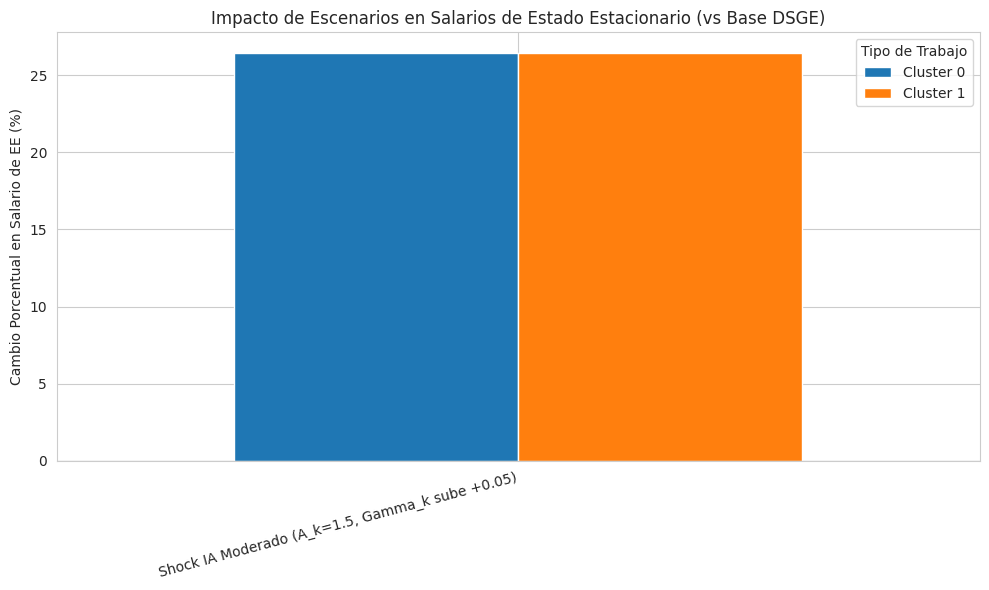


--- Fin de la Celda F (REVISADA): Análisis Contrafactual DSGE (s_K endógeno en shocks) ---

IMPORTANTE: Este análisis compara ESTADOS ESTACIONARIOS de tu modelo DSGE.
            El s_K en los escenarios de shock AHORA es un resultado del modelo.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy # Para copiar diccionarios de parámetros

print("--- Celda F (REVISADA): Iniciando Análisis Contrafactual DSGE (s_K endógeno en shocks) ---")

# --- 1. VERIFICAR VARIABLES Y FUNCIONES NECESARIAS ---
required_vars_for_stepF_rev = [
    'full_calibrated_dsge_params', # Del Paso E (Optimización DSGE)
    'empirical_targets',         # De la Celda A (Configuración)
    'cluster_names',             # De la Celda A
    'base_cluster_for_norm',     # De la Celda A
    'solve_steady_state_DSGE',   # De la Celda C
    'solve_equilibrium'          # De la Celda B
]
missing_vars_stepF_rev = [var for var in required_vars_for_stepF_rev if var not in globals()]
if missing_vars_stepF_rev:
    print(f"ERROR CRÍTICO: Faltan variables o funciones de celdas anteriores: {missing_vars_stepF_rev}.")
    raise NameError(f"Dependencias no encontradas para la Celda F (Revisada): {missing_vars_stepF_rev}")

print("Variables y funciones necesarias encontradas.")

# --- 2. ESTADO ESTACIONARIO BASE (CALIBRADO) ---
print("\nCalculando/Recuperando el Estado Estacionario BASE con parámetros DSGE calibrados...")
base_A_params = {f'A_{cn}': full_calibrated_dsge_params[f'A_{cn}'] for cn in cluster_names}
base_beta = full_calibrated_dsge_params['beta']

# Para el base, solve_steady_state_DSGE usa empirical_targets['s_K'] para derivar Gammas
# y el s_K del modelo resultante debe coincidir con ese target.
ss_base_results = solve_steady_state_DSGE(
    current_A_params_dict=base_A_params,
    beta_trial=base_beta,
    fixed_params=full_calibrated_dsge_params,
    s_K_target_from_data=empirical_targets['s_K']
)

if ss_base_results is None or pd.isna(ss_base_results.get('Y_ss')):
    print("ERROR CRÍTICO: No se pudo calcular el estado estacionario base. No se puede continuar.")
    raise ValueError("Fallo en el cálculo del escenario base para el análisis contrafactual.")

print("\nResultados del Estado Estacionario Base (Calibrado):")
for var, val in ss_base_results.items():
    if isinstance(val, float): print(f"  {var}: {val:.4f}")
    else: print(f"  {var}: {val}")

# Guardar valores base para comparaciones
y_base_value = ss_base_results['Y_ss']
w_base_values = {cn: ss_base_results.get(f'w_{cn}_ss') for cn in cluster_names}
sK_base_value = ss_base_results['s_K_ss_model_check'] # Este es el s_K que el modelo base replica

# --- 3. DEFINIR Y SIMULAR ESCENARIOS CONTRAFACTUALES DSGE ---
counterfactual_dsge_results_dict = {}
scenario_dsge_definitions = {}

# --- Escenario CF-DSGE 1: Shock Tecnológico en IA (A_k aumenta Y Gamma_k aumenta) ---
scenario_name_cf_dsge1 = "Shock IA Moderado (A_k=1.5, Gamma_k sube +0.05)"
print(f"\n--- Escenario Contrafactual DSGE 1: {scenario_name_cf_dsge1} ---")

params_cf_dsge1 = copy.deepcopy(full_calibrated_dsge_params)
original_Ak_cf1 = params_cf_dsge1['A_k']
params_cf_dsge1['A_k'] = 1.5 # Nuevo valor para A_k

# Definir el cambio exógeno en Gammas para este shock
# Gamma_k base era ~0.3651 (de la calibración)
# Supongamos que el shock aumenta Gamma_k en 0.05 (IA hace 5pp más de tareas)
Gammas_shock_cf1 = {}
base_Gamma_k_for_shock = empirical_targets['s_K'] / (original_Ak_cf1**(params_cf_dsge1['lambda_'] - 1)) # Recalcular Gamma_k base original
Gammas_shock_cf1['Gamma_k'] = base_Gamma_k_for_shock + 0.05
Gammas_shock_cf1['Gamma_k'] = np.clip(Gammas_shock_cf1['Gamma_k'], 0, 0.99) # Asegurar que esté en rango

Gamma_L_remaining_cf1 = 1.0 - Gammas_shock_cf1['Gamma_k']
total_Lg_cf1 = sum(params_cf_dsge1[f'L_{cn}'] for cn in cluster_names)
if total_Lg_cf1 > 0:
    for cn in cluster_names:
        Gammas_shock_cf1[f'Gamma_{cn}'] = Gamma_L_remaining_cf1 * (params_cf_dsge1[f'L_{cn}'] / total_Lg_cf1)
else: # Si no hay trabajo, todas las tareas laborales son cero
    for cn in cluster_names: Gammas_shock_cf1[f'Gamma_{cn}'] = 0.0

# Calcular el s_K_target "falso" para este shock, que es el s_K que RESULTARÁ del modelo
s_K_target_for_shock_cf1 = (params_cf_dsge1['A_k']**(params_cf_dsge1['lambda_'] - 1)) * Gammas_shock_cf1['Gamma_k']

scenario_dsge_definitions[scenario_name_cf_dsge1] = (
    f"A_k: {original_Ak_cf1:.2f} -> {params_cf_dsge1['A_k']:.2f}; "
    f"Gamma_k: {base_Gamma_k_for_shock:.3f} -> {Gammas_shock_cf1['Gamma_k']:.3f} "
    f"(s_K_model resultante: {s_K_target_for_shock_cf1:.3f})"
)
print(f"Asumiendo: {scenario_dsge_definitions[scenario_name_cf_dsge1]}")
print(f"  Gammas para el shock CF1: {Gammas_shock_cf1}")


A_params_cf_dsge1 = {f'A_{cn}': params_cf_dsge1[f'A_{cn}'] for cn in cluster_names}
beta_cf_dsge1 = params_cf_dsge1['beta']

try:
    # Llamamos a solve_steady_state_DSGE pasándole el s_K que resultará de las nuevas Gammas y A_k
    # Esto asegura que use las Gammas_shock_cf1 correctas internamente.
    results_cf_dsge1 = solve_steady_state_DSGE(
        current_A_params_dict=A_params_cf_dsge1,
        beta_trial=beta_cf_dsge1,
        fixed_params=params_cf_dsge1, # Contiene el nuevo A_k
        s_K_target_from_data=s_K_target_for_shock_cf1 # Este es el s_K que el modelo generará
    )
    # La función solve_steady_state_DSGE recalculará las Gammas internamente
    # usando s_K_target_for_shock_cf1, A_k (shockeado), y lambda. Estas Gammas
    # DEBEN ser idénticas a Gammas_shock_cf1 si la matemática es consistente.
    # El s_K_ss_model_check que devuelva debe ser igual a s_K_target_for_shock_cf1.

    counterfactual_dsge_results_dict[scenario_name_cf_dsge1] = results_cf_dsge1
    if results_cf_dsge1:
        print(f"  Resultados {scenario_name_cf_dsge1}: Y_ss={results_cf_dsge1.get('Y_ss', np.nan):.3f}, K_ss={results_cf_dsge1.get('K_ss',np.nan):.3f}, s_K_model={results_cf_dsge1.get('s_K_ss_model_check',np.nan):.3f}")
    else:
        print(f"  ERROR: No se pudo resolver el estado estacionario para {scenario_name_cf_dsge1}")

except Exception as e_cf_dsge1:
    print(f"  ERROR calculando escenario '{scenario_name_cf_dsge1}': {e_cf_dsge1}")


# --- (Puedes añadir más escenarios aquí, ej. uno donde solo un tipo de trabajo es afectado por las Gammas) ---

# --- 4. Resumen Comparativo de Estados Estacionarios y Visualización ---
# (Esta sección es idéntica a la que te di en la respuesta anterior,
#  ya que solo depende de los diccionarios `ss_base_results` y `counterfactual_dsge_results_dict`)

print("\n" + "="*80)
print("--- Resumen del Análisis Contrafactual DSGE (Comparación de Estados Estacionarios) ---")
print("="*80)

summary_dsge_table_data = []

# Fila para el Escenario Base
if ss_base_results and pd.notna(ss_base_results.get('Y_ss')):
    base_dsge_row = {'Escenario': 'BASE DSGE (Calibrado)',
                     'Y_ss': ss_base_results['Y_ss'],
                     'K_ss': ss_base_results['K_ss'],
                     'C_ss': ss_base_results['C_ss'],
                     'I_ss': ss_base_results['I_ss'],
                     's_K_ss': ss_base_results['s_K_ss_model_check'],
                     'r_ss_net': ss_base_results['r_ss_net']
                    }
    for cn in cluster_names:
        base_dsge_row[f'w_{cn}_ss'] = ss_base_results.get(f'w_{cn}_ss')
        w_base_ss_for_ratio = ss_base_results.get(f'w_{base_cluster_for_norm}_ss')
        if cn != base_cluster_for_norm and pd.notna(w_base_ss_for_ratio) and w_base_ss_for_ratio > 1e-9:
            base_dsge_row[f'w_{cn}/w_{base_cluster_for_norm}'] = ss_base_results.get(f'w_{cn}_ss') / w_base_ss_for_ratio
        elif cn == base_cluster_for_norm:
            base_dsge_row[f'w_{cn}/w_{base_cluster_for_norm}'] = 1.0
    base_dsge_row['Detalles'] = f"y_base={y_base_value:.3f}" # y_base_value se definió antes
    summary_dsge_table_data.append(base_dsge_row)
else:
    print("ADVERTENCIA: No se pudieron cargar los resultados del escenario base para el resumen.")
    summary_dsge_table_data.append({'Escenario': 'BASE DSGE (Calibrado)', 'Detalles': "ERROR EN CÁLCULO DE EE BASE"})

# Filas para los escenarios contrafactuales
for scenario_name, cf_ss_data in counterfactual_dsge_results_dict.items():
    if cf_ss_data is None or pd.isna(cf_ss_data.get('Y_ss')):
        print(f"ADVERTENCIA: Resultados para el escenario DSGE '{scenario_name}' son inválidos. Se omitirá del resumen detallado.")
        row = {'Escenario': scenario_name, 'Y_ss': np.nan, 'K_ss': np.nan, 'C_ss': np.nan, 'I_ss': np.nan,
               's_K_ss': np.nan, 'r_ss_net': np.nan}
        for cn in cluster_names:
            row[f'w_{cn}_ss'] = np.nan
            row[f'w_{cn}/w_{base_cluster_for_norm}'] = np.nan
        row['Detalles'] = scenario_dsge_definitions.get(scenario_name, '') + " - ERROR EN CÁLCULO DE EE"
        summary_dsge_table_data.append(row)
        continue

    row = {'Escenario': scenario_name,
           'Y_ss': cf_ss_data['Y_ss'], 'K_ss': cf_ss_data['K_ss'],
           'C_ss': cf_ss_data['C_ss'], 'I_ss': cf_ss_data['I_ss'],
           's_K_ss': cf_ss_data['s_K_ss_model_check'], 'r_ss_net': cf_ss_data['r_ss_net']
          }
    for cn in cluster_names:
        row[f'w_{cn}_ss'] = cf_ss_data.get(f'w_{cn}_ss')
        w_base_for_cf_ratio = cf_ss_data.get(f'w_{base_cluster_for_norm}_ss')
        if cn != base_cluster_for_norm and pd.notna(w_base_for_cf_ratio) and w_base_for_cf_ratio > 1e-9:
            row[f'w_{cn}/w_{base_cluster_for_norm}'] = cf_ss_data.get(f'w_{cn}_ss') / w_base_for_cf_ratio
        elif cn == base_cluster_for_norm:
             row[f'w_{cn}/w_{base_cluster_for_norm}'] = 1.0
    row['Detalles'] = scenario_dsge_definitions.get(scenario_name, '')
    summary_dsge_table_data.append(row)

if summary_dsge_table_data:
    summary_dsge_df = pd.DataFrame(summary_dsge_table_data)
    cols_to_show = ['Escenario', 'Y_ss', 'K_ss', 'C_ss', 'I_ss', 's_K_ss', 'r_ss_net']
    for cn in cluster_names: cols_to_show.append(f'w_{cn}_ss')
    for cn_ratio in cluster_names:
        if cn_ratio != base_cluster_for_norm : cols_to_show.append(f'w_{cn_ratio}/w_{base_cluster_for_norm}')
        elif len(cluster_names) == 1 : cols_to_show.append(f'w_{cn_ratio}/w_{base_cluster_for_norm}')
    cols_to_show.append('Detalles')
    summary_dsge_df_ordered = summary_dsge_df[[col for col in cols_to_show if col in summary_dsge_df.columns]]
    print(summary_dsge_df_ordered.to_string(index=False, float_format='{:.3f}'.format))

    # --- Visualización: Cambios Porcentuales en Salarios Absolutos de EE ---
    plot_data_w_levels_pct_change = []
    plot_labels_w_levels_pct_change = []
    if ss_base_results and pd.notna(ss_base_results.get('Y_ss')):
        for scenario_name_plot, cf_data_plot in counterfactual_dsge_results_dict.items():
            if cf_data_plot and pd.notna(cf_data_plot.get('Y_ss')):
                plot_labels_w_levels_pct_change.append(scenario_name_plot)
                level_changes_pct = []
                for cn_plot in cluster_names:
                    w_cf = cf_data_plot.get(f'w_{cn_plot}_ss', np.nan)
                    w_b = ss_base_results.get(f'w_{cn_plot}_ss', np.nan)
                    if pd.notna(w_cf) and pd.notna(w_b) and w_b > 1e-9:
                        level_changes_pct.append(((w_cf / w_b) - 1) * 100)
                    else:
                        level_changes_pct.append(np.nan)
                plot_data_w_levels_pct_change.append(level_changes_pct)

        if plot_data_w_levels_pct_change:
            df_plot_levels_pct = pd.DataFrame(plot_data_w_levels_pct_change, index=plot_labels_w_levels_pct_change,
                                          columns=[f"Cluster {cn}" for cn in cluster_names])
            ax_levels_pct = df_plot_levels_pct.plot(kind='bar', figsize=(10, 6), width=0.8)
            ax_levels_pct.set_ylabel('Cambio Porcentual en Salario de EE (%)')
            ax_levels_pct.set_title('Impacto de Escenarios en Salarios de Estado Estacionario (vs Base DSGE)')
            ax_levels_pct.axhline(0, color='gray', linewidth=0.8)
            plt.xticks(rotation=15, ha='right')
            plt.legend(title="Tipo de Trabajo")
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo hay suficientes datos de escenarios contrafactuales DSGE válidos para graficar cambios salariales.")
else:
    print("No se generaron resultados para el resumen contrafactual DSGE.")

print("\n--- Fin de la Celda F (REVISADA): Análisis Contrafactual DSGE (s_K endógeno en shocks) ---")
print("\nIMPORTANTE: Este análisis compara ESTADOS ESTACIONARIOS de tu modelo DSGE.")
print("            El s_K en los escenarios de shock AHORA es un resultado del modelo.")

--- Celda G: Iniciando Visualizaciones de Resultados DSGE ---
Variables necesarias para las gráficas encontradas.

Generando Gráfica 1: Descomposición del Output...


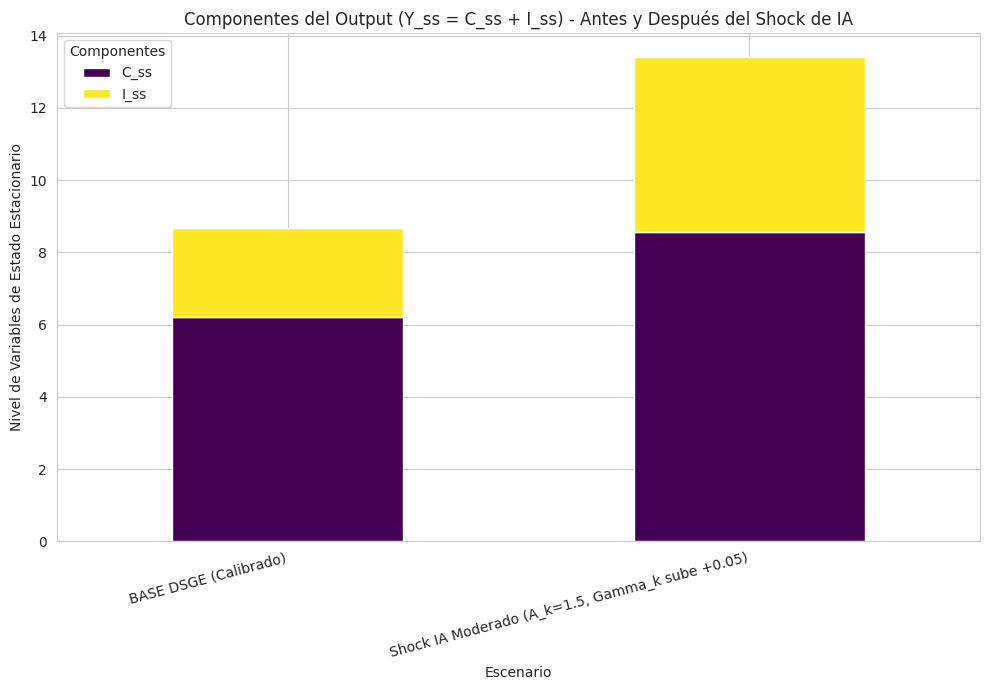


Generando Gráfica 2: Participaciones en el Ingreso...


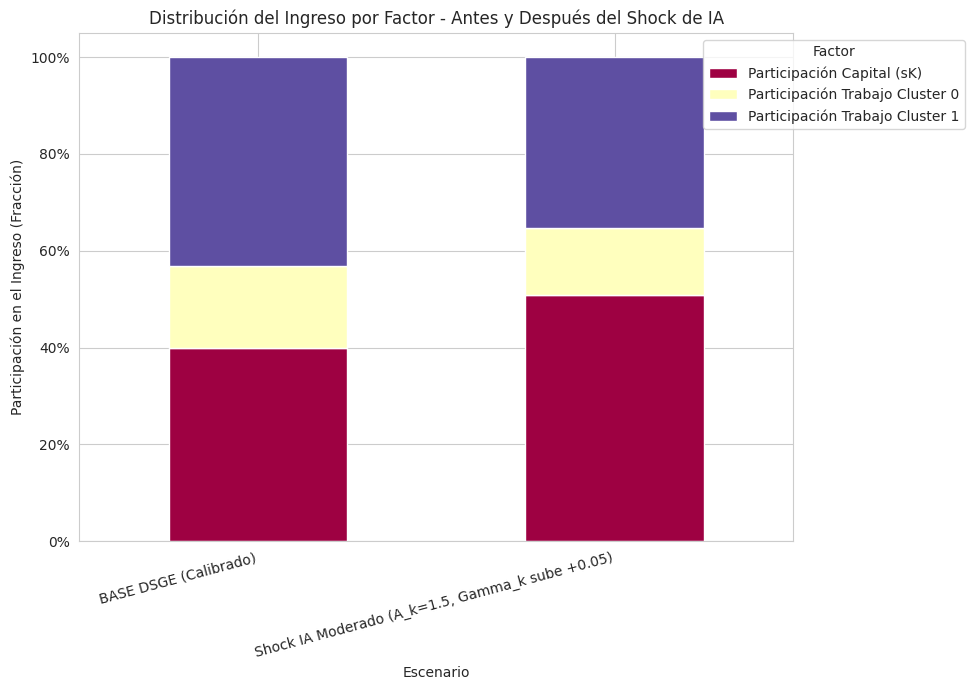


Generando Gráfica 3: Salarios Reales y Relativos...


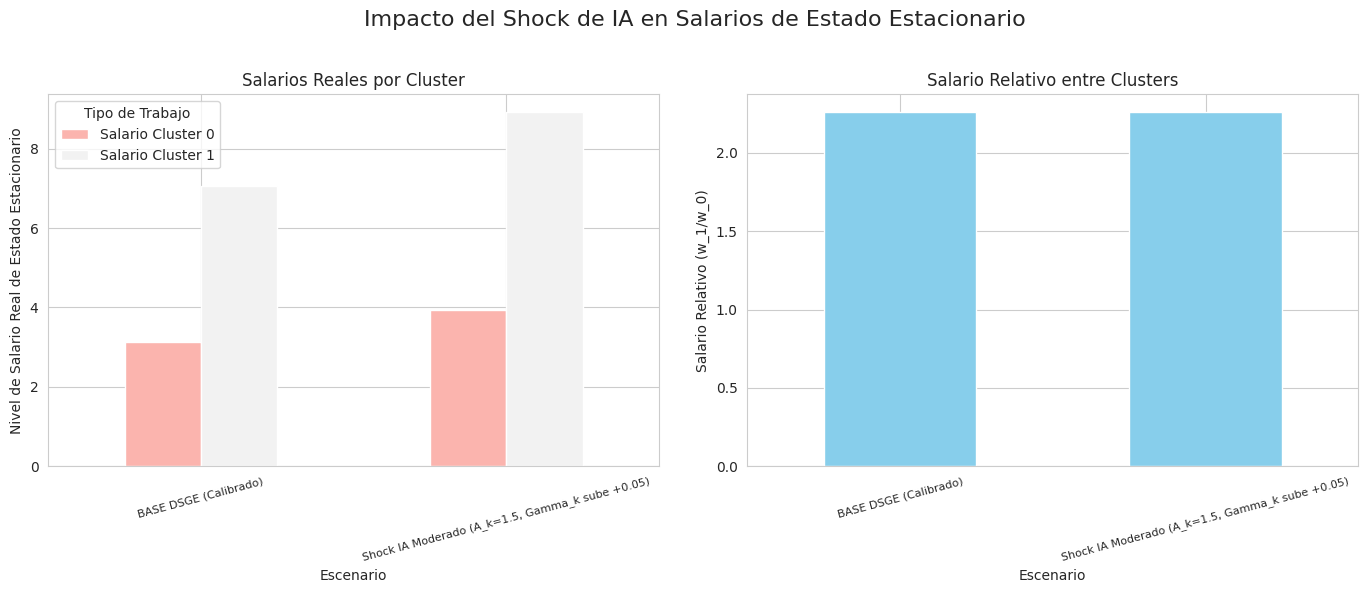


Generando Gráfica 4: Cuotas de Tarea...


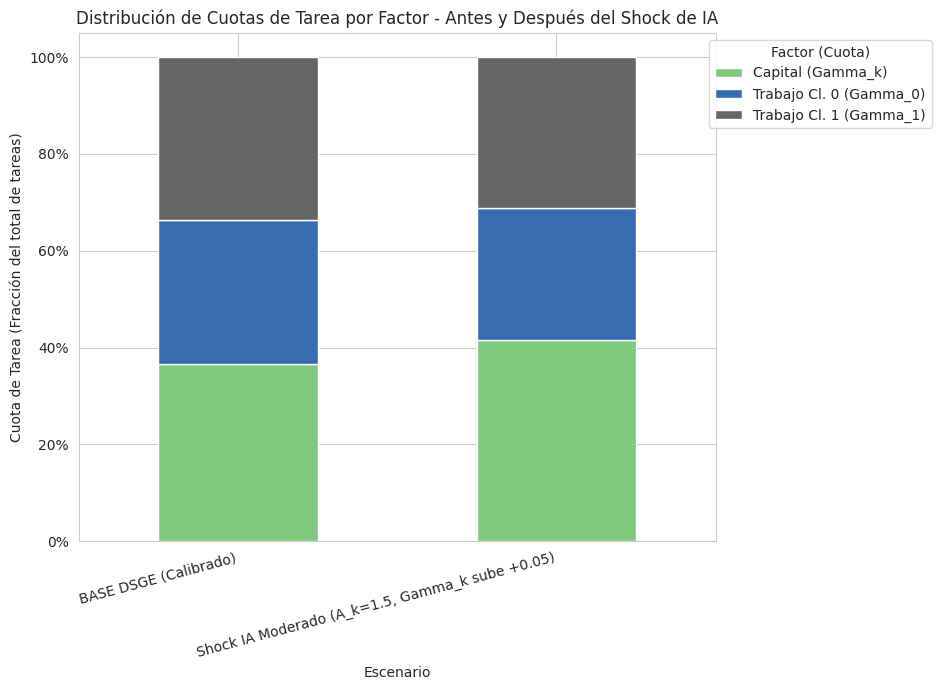


--- Fin de la Celda G: Visualizaciones DSGE ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # Para formatear ejes como porcentajes

print("--- Celda G: Iniciando Visualizaciones de Resultados DSGE ---")

# --- 1. Verificar que los DataFrames y variables necesarios existen ---
required_vars_for_plots = [
    'summary_dsge_df',             # El DataFrame resumen de la Celda F
    'ss_base_results',             # Resultados del estado estacionario base
    'counterfactual_dsge_results_dict', # Diccionario con resultados de los shocks
    'cluster_names',               # Lista de nombres de clusters (ej. ['0', '1'])
    'base_cluster_for_norm'      # Nombre del cluster base (ej. '0')
]
missing_vars_plots = [var for var in required_vars_for_plots if var not in globals()]
if missing_vars_plots:
    print(f"ERROR CRÍTICO: Faltan variables para graficar: {missing_vars_plots}.")
    print("               Asegúrate de haber ejecutado la Celda F (Análisis Contrafactual DSGE) completamente.")
    raise NameError(f"Dependencias no encontradas para las gráficas: {missing_vars_plots}")

print("Variables necesarias para las gráficas encontradas.")

# --- Preparar Datos para Gráficas ---
# Usaremos summary_dsge_df que ya tiene gran parte de la información.
# Asegurémonos de que el DataFrame no esté vacío y contenga escenarios de shock.
shock_scenarios_df = summary_dsge_df[summary_dsge_df['Escenario'] != 'BASE DSGE (Calibrado)'].copy()
if shock_scenarios_df.empty:
    print("No se encontraron escenarios de shock en summary_dsge_df para graficar.")
else:
    # --- Gráfica 1: Descomposición del Output (Y_ss) y sus Componentes (C_ss, I_ss) ---
    print("\nGenerando Gráfica 1: Descomposición del Output...")
    plot_df_agg = summary_dsge_df.set_index('Escenario')[['C_ss', 'I_ss']]

    ax1 = plot_df_agg.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
    ax1.set_ylabel('Nivel de Variables de Estado Estacionario')
    ax1.set_title('Componentes del Output (Y_ss = C_ss + I_ss) - Antes y Después del Shock de IA')
    plt.xticks(rotation=15, ha='right')
    ax1.legend(title="Componentes", loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- Gráfica 2: Participaciones en el Ingreso ($s_K, s_{L0}, s_{L1}$) ---
    print("\nGenerando Gráfica 2: Participaciones en el Ingreso...")
    income_shares_data = []
    for index, row in summary_dsge_df.iterrows():
        scenario_name = row['Escenario']
        Yss = row['Y_ss']
        sKss = row['s_K_ss']
        if pd.isna(Yss) or Yss == 0 or pd.isna(sKss) : # Saltar si Yss o sKss es NaN o Yss es 0
            continue

        share_data = {'Escenario': scenario_name, 'Participación Capital (sK)': sKss}
        labor_share_total = 0
        for cn in cluster_names:
            w_cn_ss = row.get(f'w_{cn}_ss')
            # L_cn viene de full_calibrated_dsge_params o fixed_params_for_calibration_dsge
            L_cn_val = full_calibrated_dsge_params.get(f'L_{cn}', 0) # Usar el L_g fijo
            if pd.notna(w_cn_ss) and pd.notna(L_cn_val):
                share_Lcn = (w_cn_ss * L_cn_val) / Yss
                share_data[f'Participación Trabajo Cluster {cn}'] = share_Lcn
                labor_share_total += share_Lcn
            else:
                share_data[f'Participación Trabajo Cluster {cn}'] = 0 # O np.nan

        # Pequeño ajuste para que sumen 1 (debido a redondeos o si Π != 0)
        # Si el modelo tiene beneficios cero, sK + sum(sL) debería ser 1.
        # Aquí forzamos que las participaciones laborales se ajusten para que la suma sea 1-sK
        if not np.isclose(sKss + labor_share_total, 1.0) and labor_share_total > 0:
            adjustment_factor = (1.0 - sKss) / labor_share_total
            for cn in cluster_names:
                 share_data[f'Participación Trabajo Cluster {cn}'] *= adjustment_factor
        income_shares_data.append(share_data)

    if income_shares_data:
        df_income_shares = pd.DataFrame(income_shares_data).set_index('Escenario')

        ax2 = df_income_shares.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='Spectral')
        ax2.set_ylabel('Participación en el Ingreso (Fracción)')
        ax2.set_title('Distribución del Ingreso por Factor - Antes y Después del Shock de IA')
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        plt.xticks(rotation=15, ha='right')
        ax2.legend(title="Factor", loc='upper right', bbox_to_anchor=(1.25, 1.0))
        plt.tight_layout()
        plt.show()
    else:
        print("No se pudieron calcular las participaciones en el ingreso para graficar.")


    # --- Gráfica 3: Salarios Reales por Cluster y Salario Relativo ---
    print("\nGenerando Gráfica 3: Salarios Reales y Relativos...")
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 3a: Niveles de Salarios Reales
    wage_levels_data = []
    for cn in cluster_names:
        wage_levels_data.append(summary_dsge_df.set_index('Escenario')[f'w_{cn}_ss'])
    df_wage_levels = pd.concat(wage_levels_data, axis=1, keys=[f'Salario Cluster {cn}' for cn in cluster_names])

    df_wage_levels.plot(kind='bar', ax=ax3a, colormap='Pastel1')
    ax3a.set_ylabel('Nivel de Salario Real de Estado Estacionario')
    ax3a.set_title('Salarios Reales por Cluster')
    ax3a.tick_params(axis='x', rotation=15, labelsize=8) # Ajustar tamaño de etiqueta
    ax3a.legend(title="Tipo de Trabajo")

    # Gráfico 3b: Salario Relativo
    # Asumimos que la columna de salario relativo es w_Cluster1/w_Cluster0 si base_cluster_for_norm es '0'
    # y solo hay dos clusters '0' y '1'.
    non_base_cluster = [cn for cn in cluster_names if cn != base_cluster_for_norm][0]
    relative_wage_col_name = f'w_{non_base_cluster}/w_{base_cluster_for_norm}'
    if relative_wage_col_name in summary_dsge_df.columns:
        summary_dsge_df.set_index('Escenario')[relative_wage_col_name].plot(kind='bar', ax=ax3b, color='skyblue')
        ax3b.set_ylabel(f'Salario Relativo ({relative_wage_col_name})')
        ax3b.set_title('Salario Relativo entre Clusters')
        ax3b.tick_params(axis='x', rotation=15, labelsize=8)
    else:
        ax3b.text(0.5, 0.5, "Datos de salario relativo no disponibles\npara este número de clusters.",
                  horizontalalignment='center', verticalalignment='center', transform=ax3b.transAxes)


    plt.suptitle('Impacto del Shock de IA en Salarios de Estado Estacionario', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar para el suptitle
    plt.show()

    # --- Gráfica 4: Cuotas de Tarea (Gammas) - Antes y Después del Shock de IA ---
    # Necesitamos las Gammas del estado base y del(los) escenario(s) de shock.
    # Las Gammas base se calcularon en `solve_steady_state_DSGE` para el estado base.
    # Para el shock, las definimos exógenamente.
    print("\nGenerando Gráfica 4: Cuotas de Tarea...")
    gamma_data_for_plot = []

    # Gammas Base (del estado estacionario base)
    base_gammas_dict_for_plot = {}
    if ss_base_results: # Necesitamos recalcular las Gammas que produjo el EE base
        temp_params_base = full_calibrated_dsge_params.copy()
        temp_A_k_base = temp_params_base['A_k']
        temp_lambda_base = temp_params_base['lambda_']
        temp_sK_target_base = empirical_targets['s_K'] # sK del modelo base es el target

        if temp_A_k_base**(temp_lambda_base - 1) > 1e-9:
            base_Gamma_k = temp_sK_target_base / (temp_A_k_base**(temp_lambda_base - 1))
            base_Gamma_L = 1.0 - base_Gamma_k
            base_total_Lg = sum(temp_params_base[f'L_{cn}'] for cn in cluster_names)
            base_gammas_dict_for_plot['Capital (Gamma_k)'] = base_Gamma_k
            if base_total_Lg > 0:
                for cn in cluster_names:
                    base_gammas_dict_for_plot[f'Trabajo Cl. {cn} (Gamma_{cn})'] = base_Gamma_L * (temp_params_base[f'L_{cn}'] / base_total_Lg)
            else:
                 for cn in cluster_names: base_gammas_dict_for_plot[f'Trabajo Cl. {cn} (Gamma_{cn})'] = 0
            gamma_data_for_plot.append({'Escenario': 'BASE DSGE (Calibrado)', **base_gammas_dict_for_plot})

    # Gammas del Shock CF1 (como se definieron en la Celda F)
    if "Shock IA Moderado (A_k=1.5, Gamma_k sube +0.05)" in scenario_dsge_definitions:
        # Reconstruir las Gammas del shock CF1 tal como se definieron en Celda F
        # Necesitamos los parámetros del shock CF1 para A_k y lambda
        params_cf_dsge1_plot = copy.deepcopy(full_calibrated_dsge_params)
        params_cf_dsge1_plot['A_k'] = 1.5 # A_k del shock

        # Gamma_k exógena del shock
        # original_Ak_cf1 fue A_k base
        original_Ak_cf1_plot = full_calibrated_dsge_params['A_k']
        base_Gamma_k_for_shock_plot = empirical_targets['s_K'] / (original_Ak_cf1_plot**(params_cf_dsge1_plot['lambda_'] - 1))

        Gamma_k_shock1 = base_Gamma_k_for_shock_plot + 0.05
        Gamma_k_shock1 = np.clip(Gamma_k_shock1, 0, 0.99)
        Gamma_L_shock1 = 1.0 - Gamma_k_shock1
        total_Lg_shock1 = sum(params_cf_dsge1_plot[f'L_{cn}'] for cn in cluster_names)

        shock1_gammas_dict = {'Capital (Gamma_k)': Gamma_k_shock1}
        if total_Lg_shock1 > 0:
            for cn in cluster_names:
                shock1_gammas_dict[f'Trabajo Cl. {cn} (Gamma_{cn})'] = Gamma_L_shock1 * (params_cf_dsge1_plot[f'L_{cn}'] / total_Lg_shock1)
        else:
            for cn in cluster_names: shock1_gammas_dict[f'Trabajo Cl. {cn} (Gamma_{cn})'] = 0.0
        gamma_data_for_plot.append({'Escenario': "Shock IA Moderado (A_k=1.5, Gamma_k sube +0.05)", **shock1_gammas_dict})

    if gamma_data_for_plot:
        df_gamma_plot = pd.DataFrame(gamma_data_for_plot).set_index('Escenario')
        ax4 = df_gamma_plot.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='Accent')
        ax4.set_ylabel('Cuota de Tarea (Fracción del total de tareas)')
        ax4.set_title('Distribución de Cuotas de Tarea por Factor - Antes y Después del Shock de IA')
        ax4.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        plt.xticks(rotation=15, ha='right')
        ax4.legend(title="Factor (Cuota)", loc='upper right', bbox_to_anchor=(1.35, 1.0))
        plt.tight_layout()
        plt.show()
    else:
        print("No se pudieron generar datos para la gráfica de cuotas de tarea.")

print("\n--- Fin de la Celda G: Visualizaciones DSGE ---")